In [1]:
import sys
sys.path.append('../src')

import pre_process as pre
import pre_process_demo_helper_fcns as pre_demo
import numpy as np


def fcn_interp_1(x, y):
    return np.sin(x) * np.cos(y)

def refinement_example(fname, ele_type, num_gauss_pts, nx, ny, fcn_interp):
    x_lower, y_lower = 0, 0
    x_upper, y_upper = 10, 10
    coords, connect = pre.generate_rect_mesh_2d(ele_type, x_lower, y_lower, x_upper, y_upper, nx, ny)
    mesh_gauss_pts = pre_demo.get_all_mesh_gauss_pts(ele_type, num_gauss_pts, coords, connect)
    ground_truth = fcn_interp(mesh_gauss_pts[:, :, 0], mesh_gauss_pts[:, :, 1])
    interpolated = pre_demo.interpolate_scalar_to_gauss_pts(ele_type, num_gauss_pts, fcn_interp, coords, connect)
    pre_demo.plot_interpolation_with_error(fname, ele_type, coords, connect, mesh_gauss_pts, interpolated, ground_truth)
    return

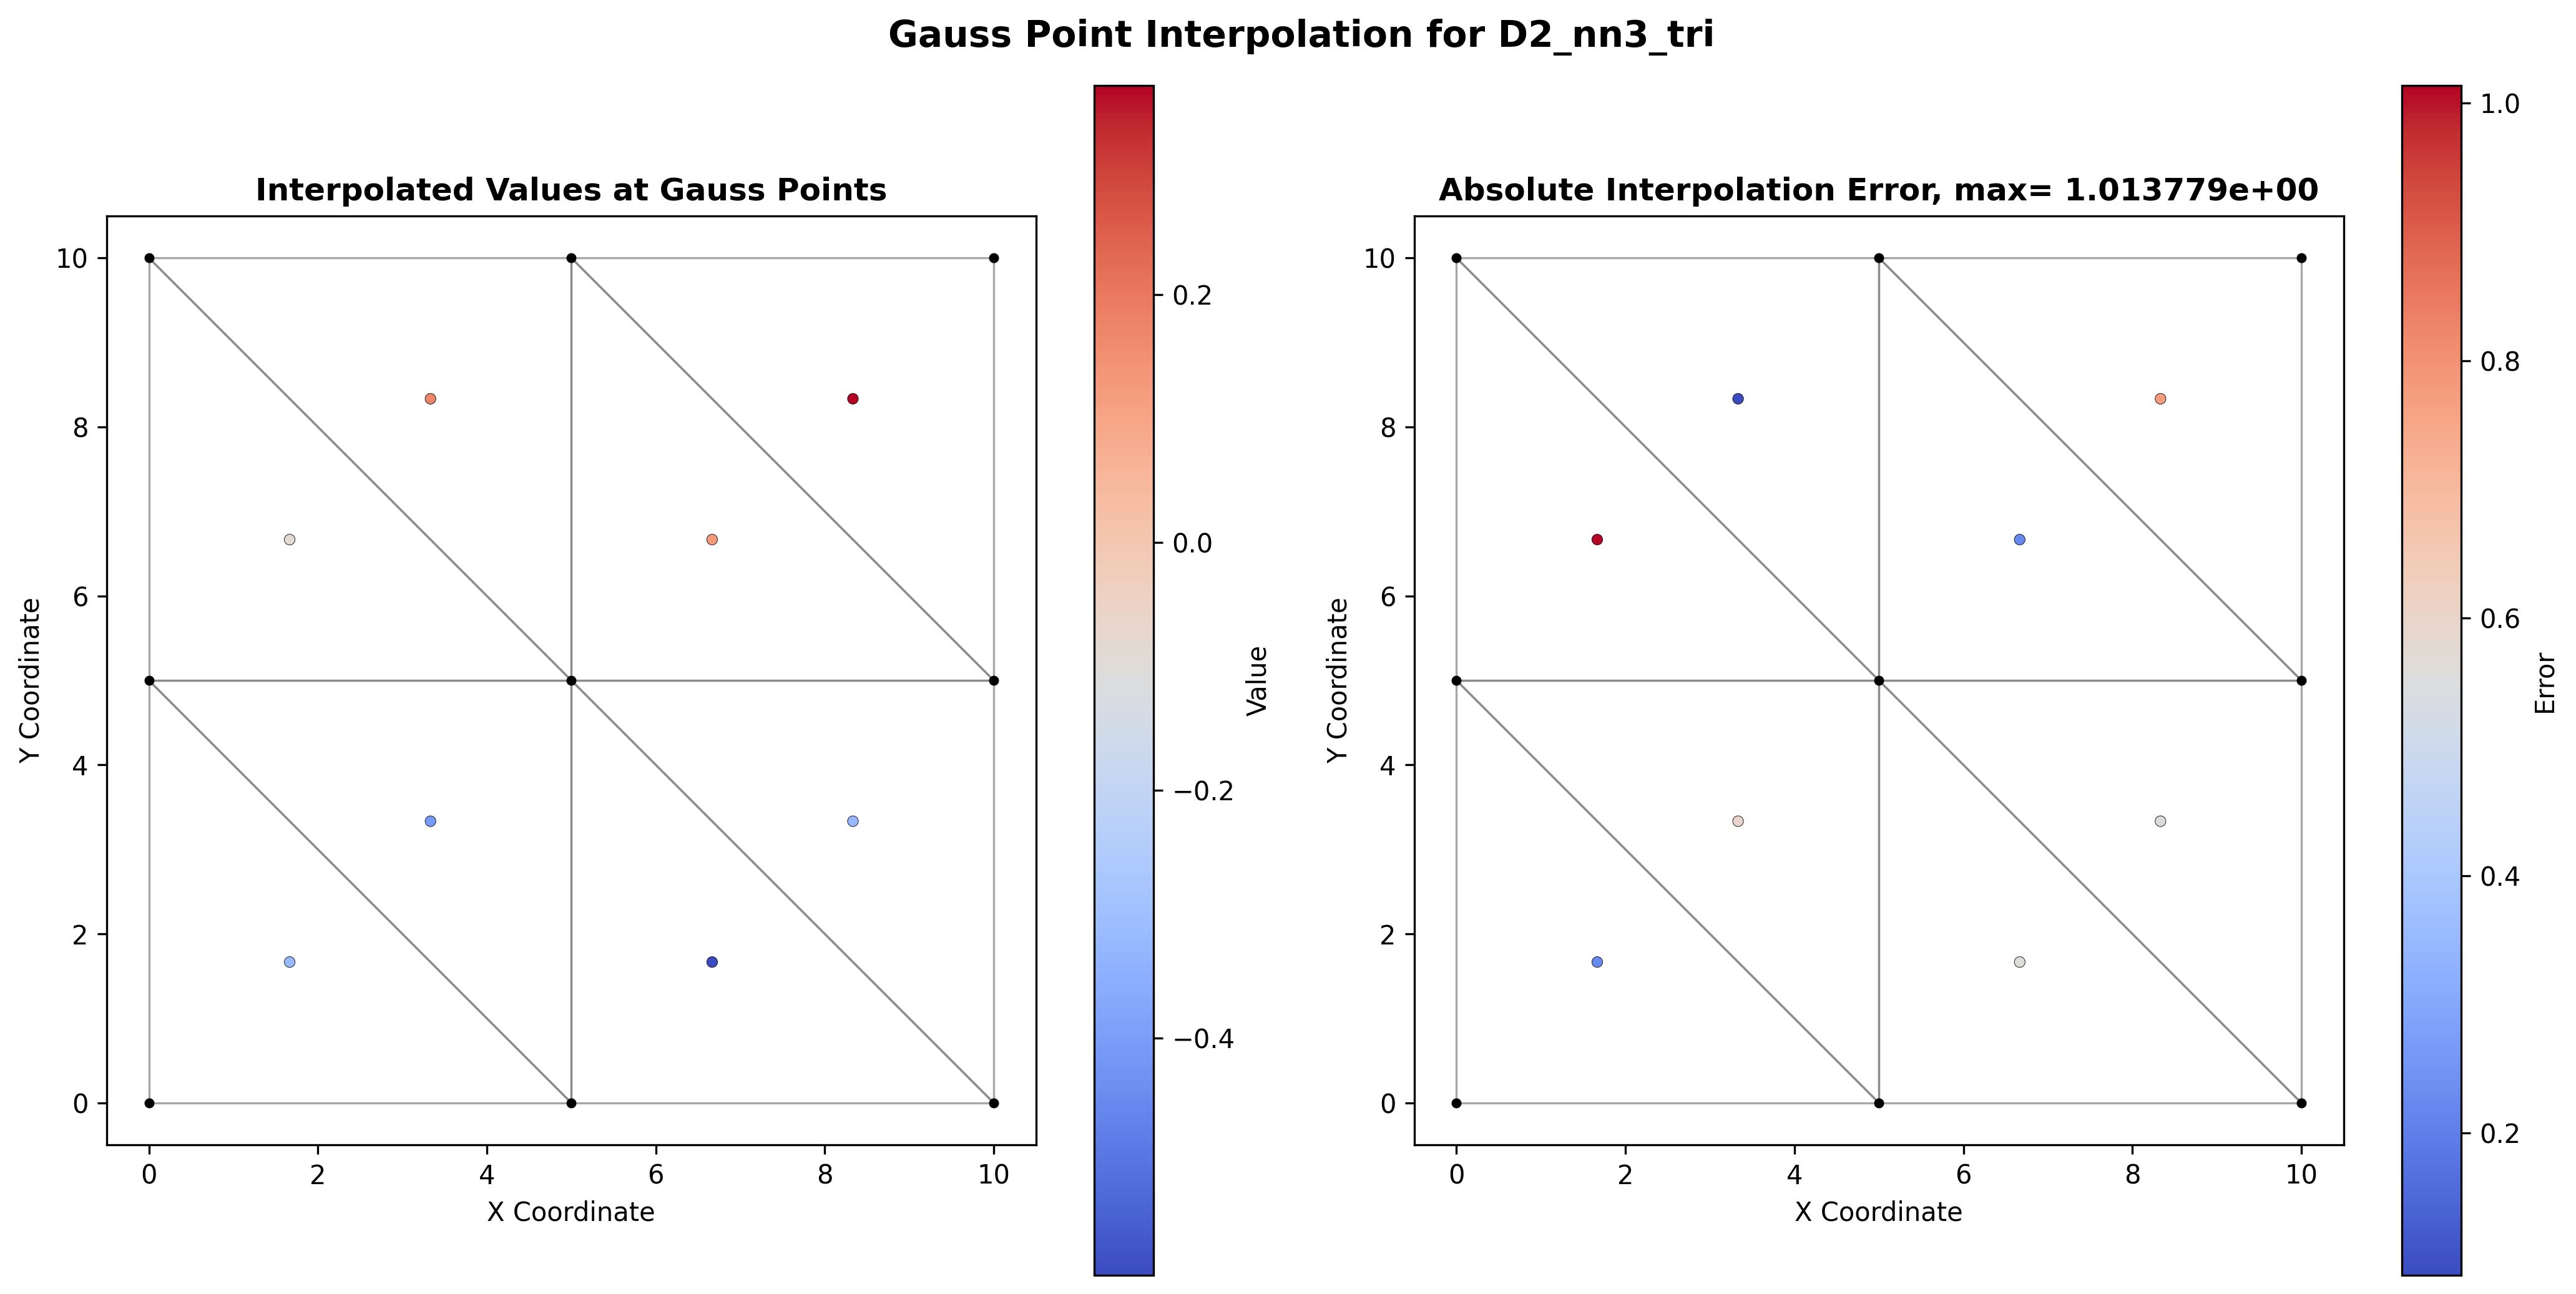

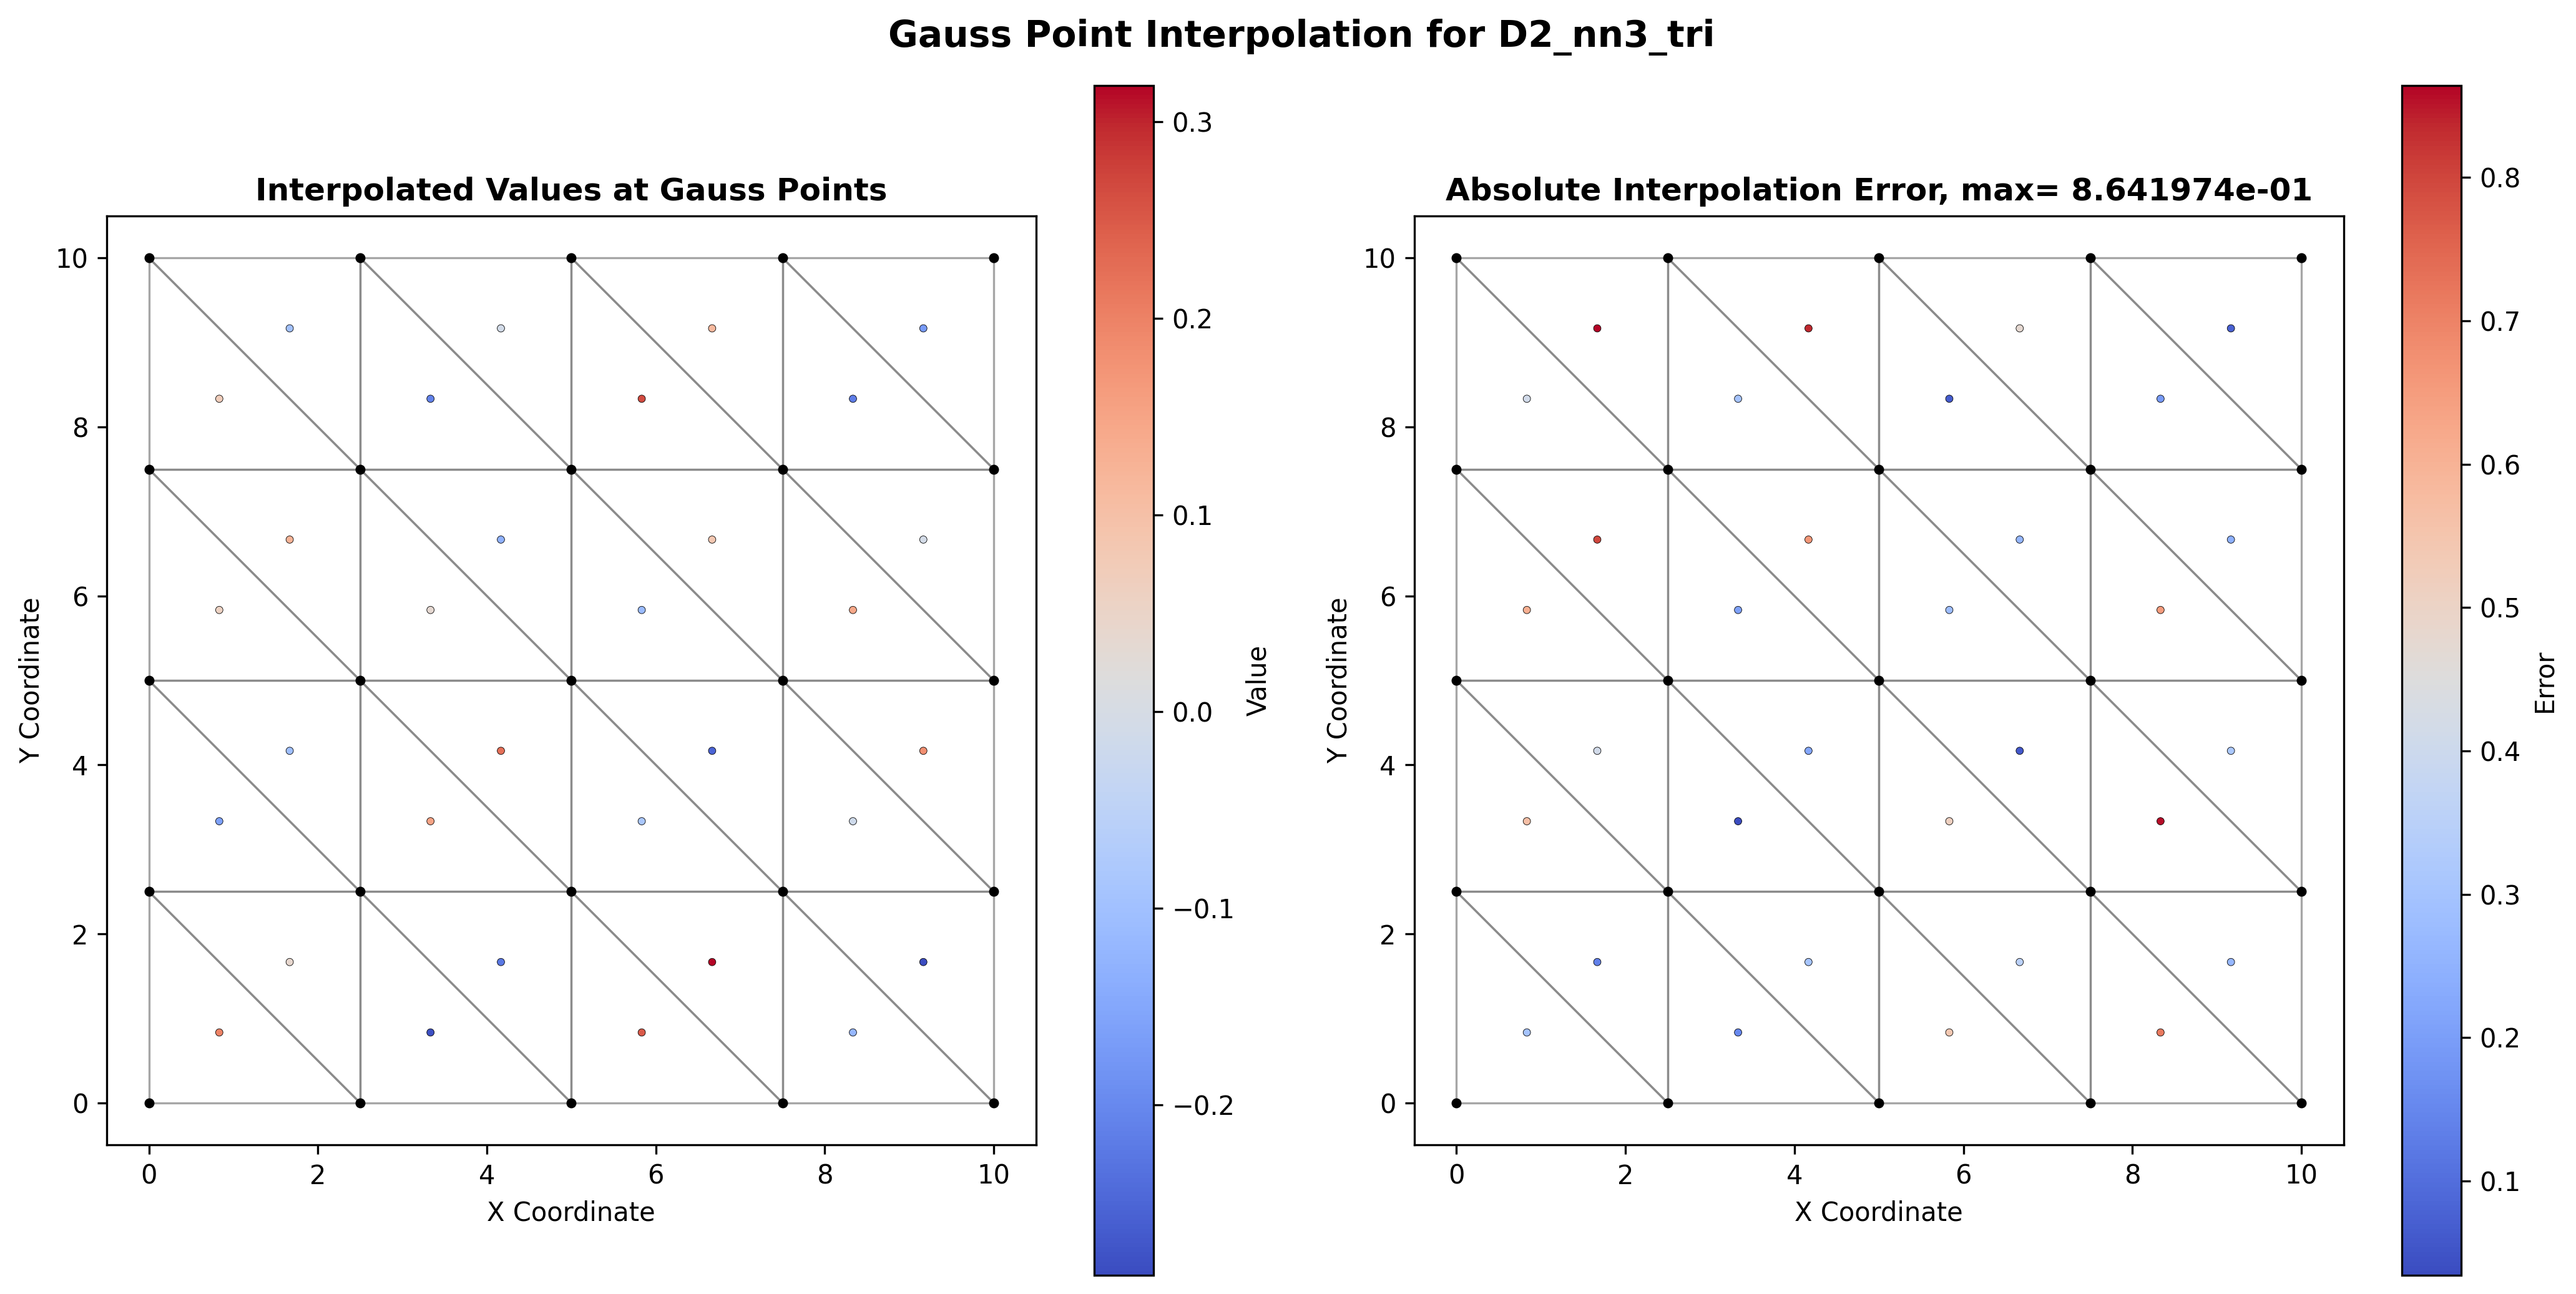

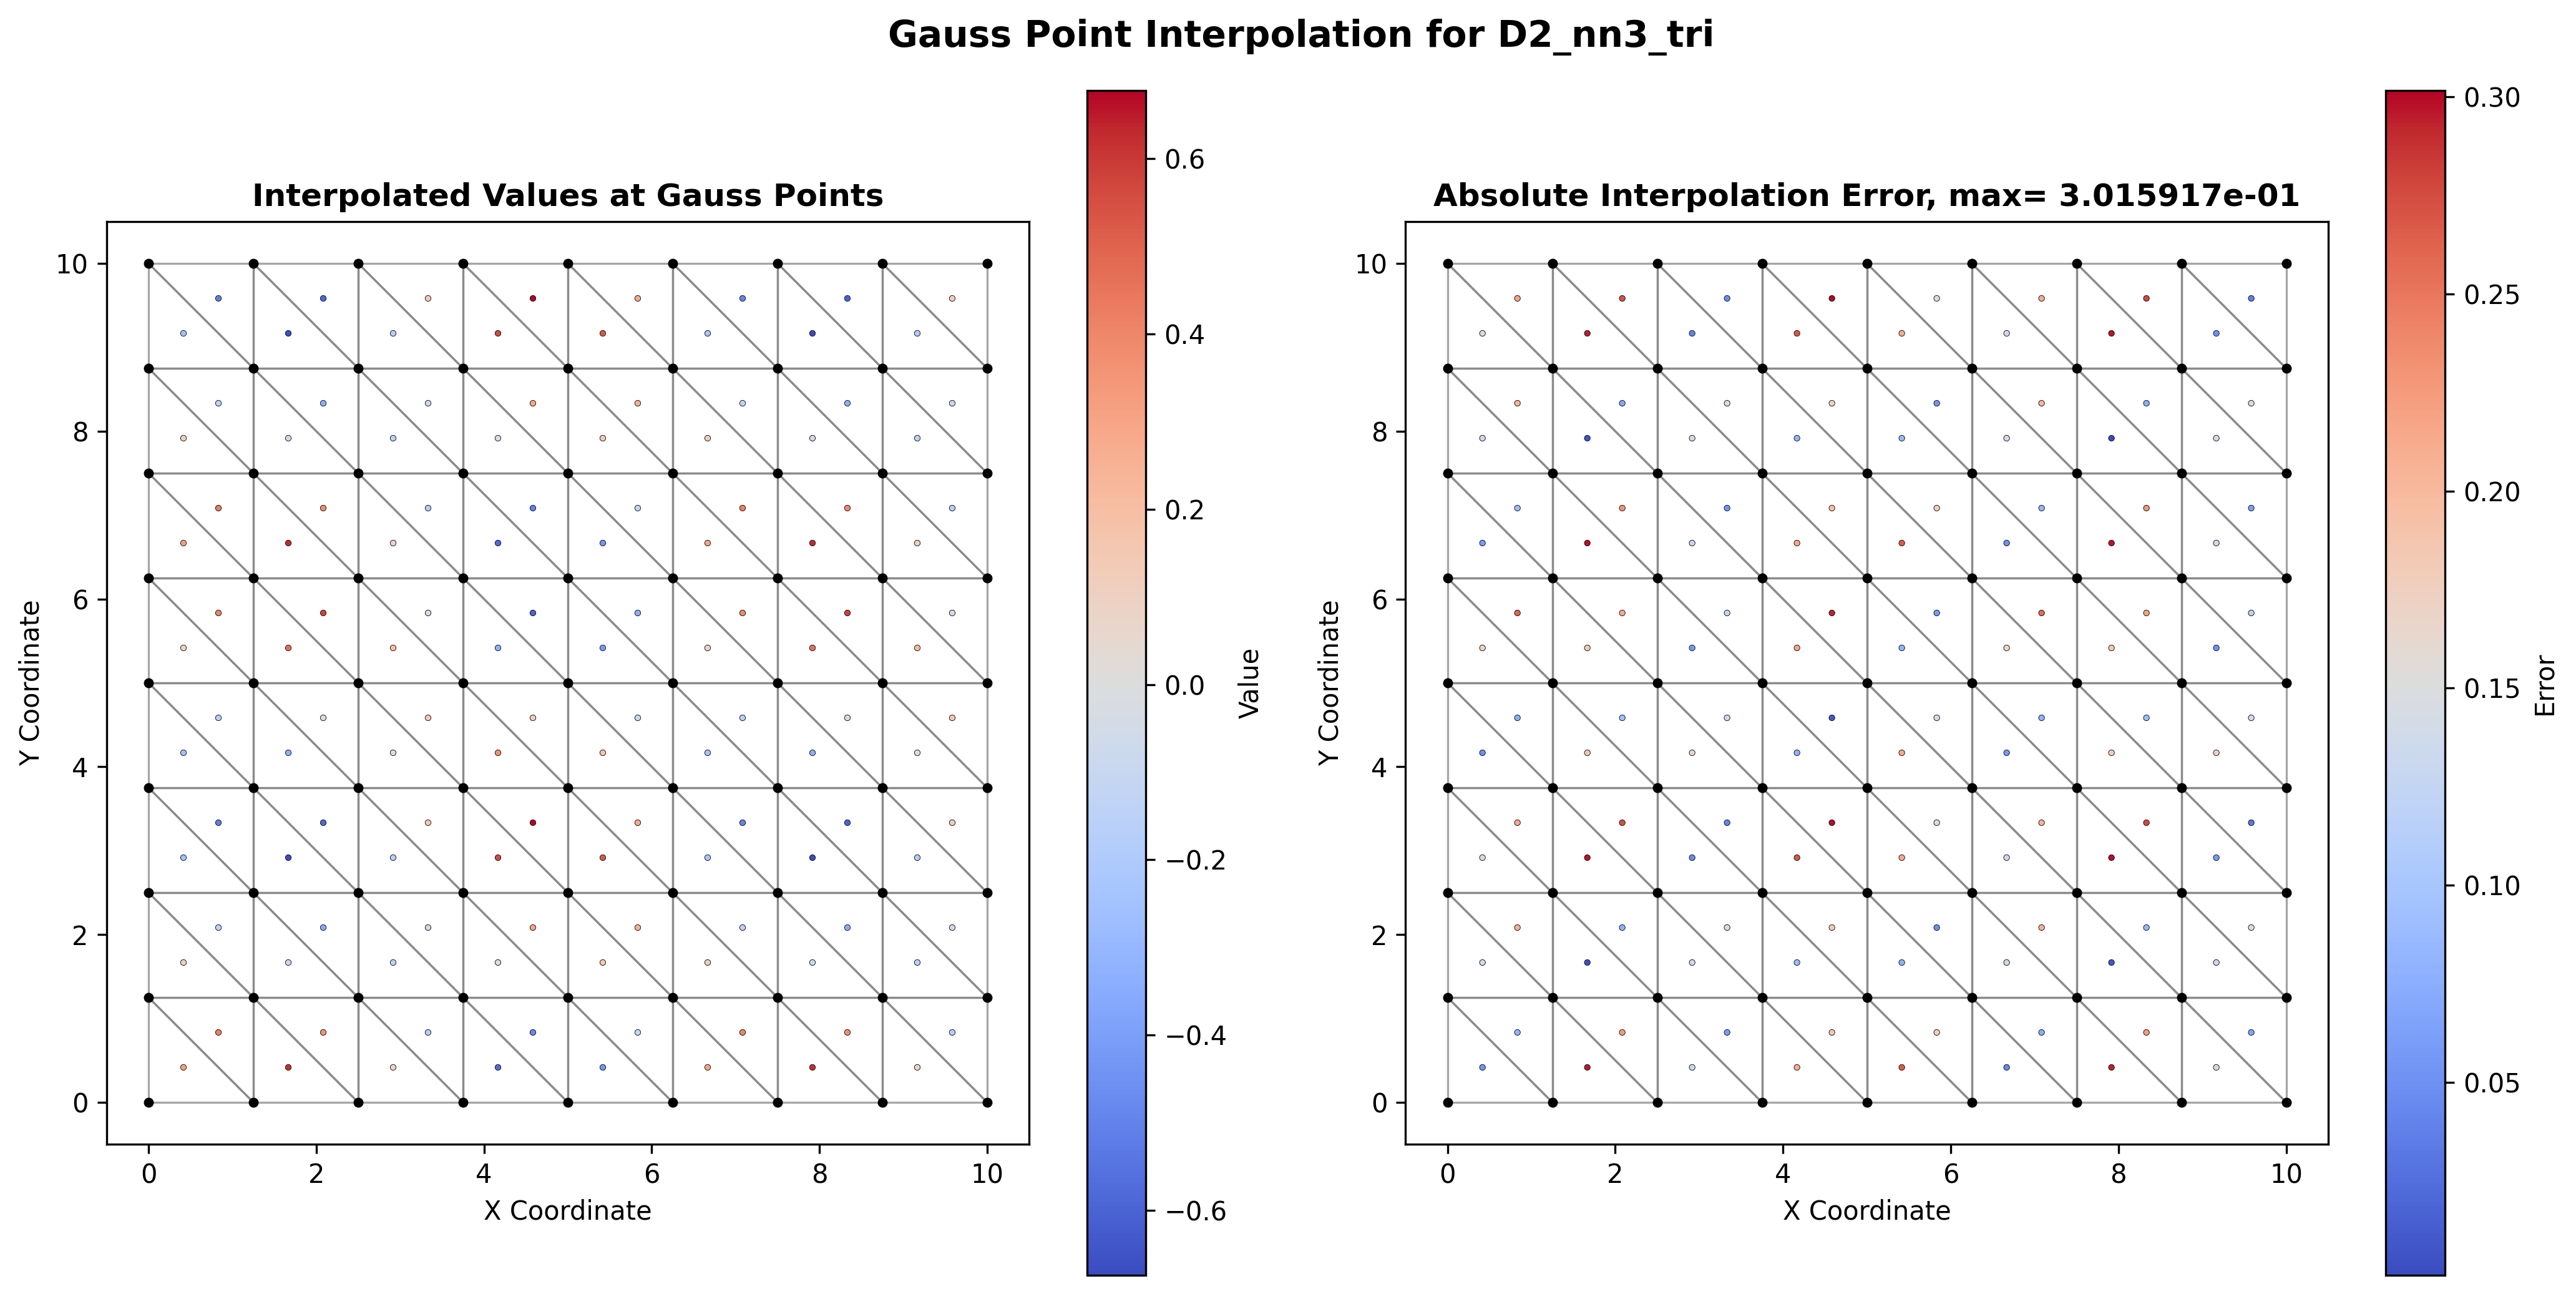

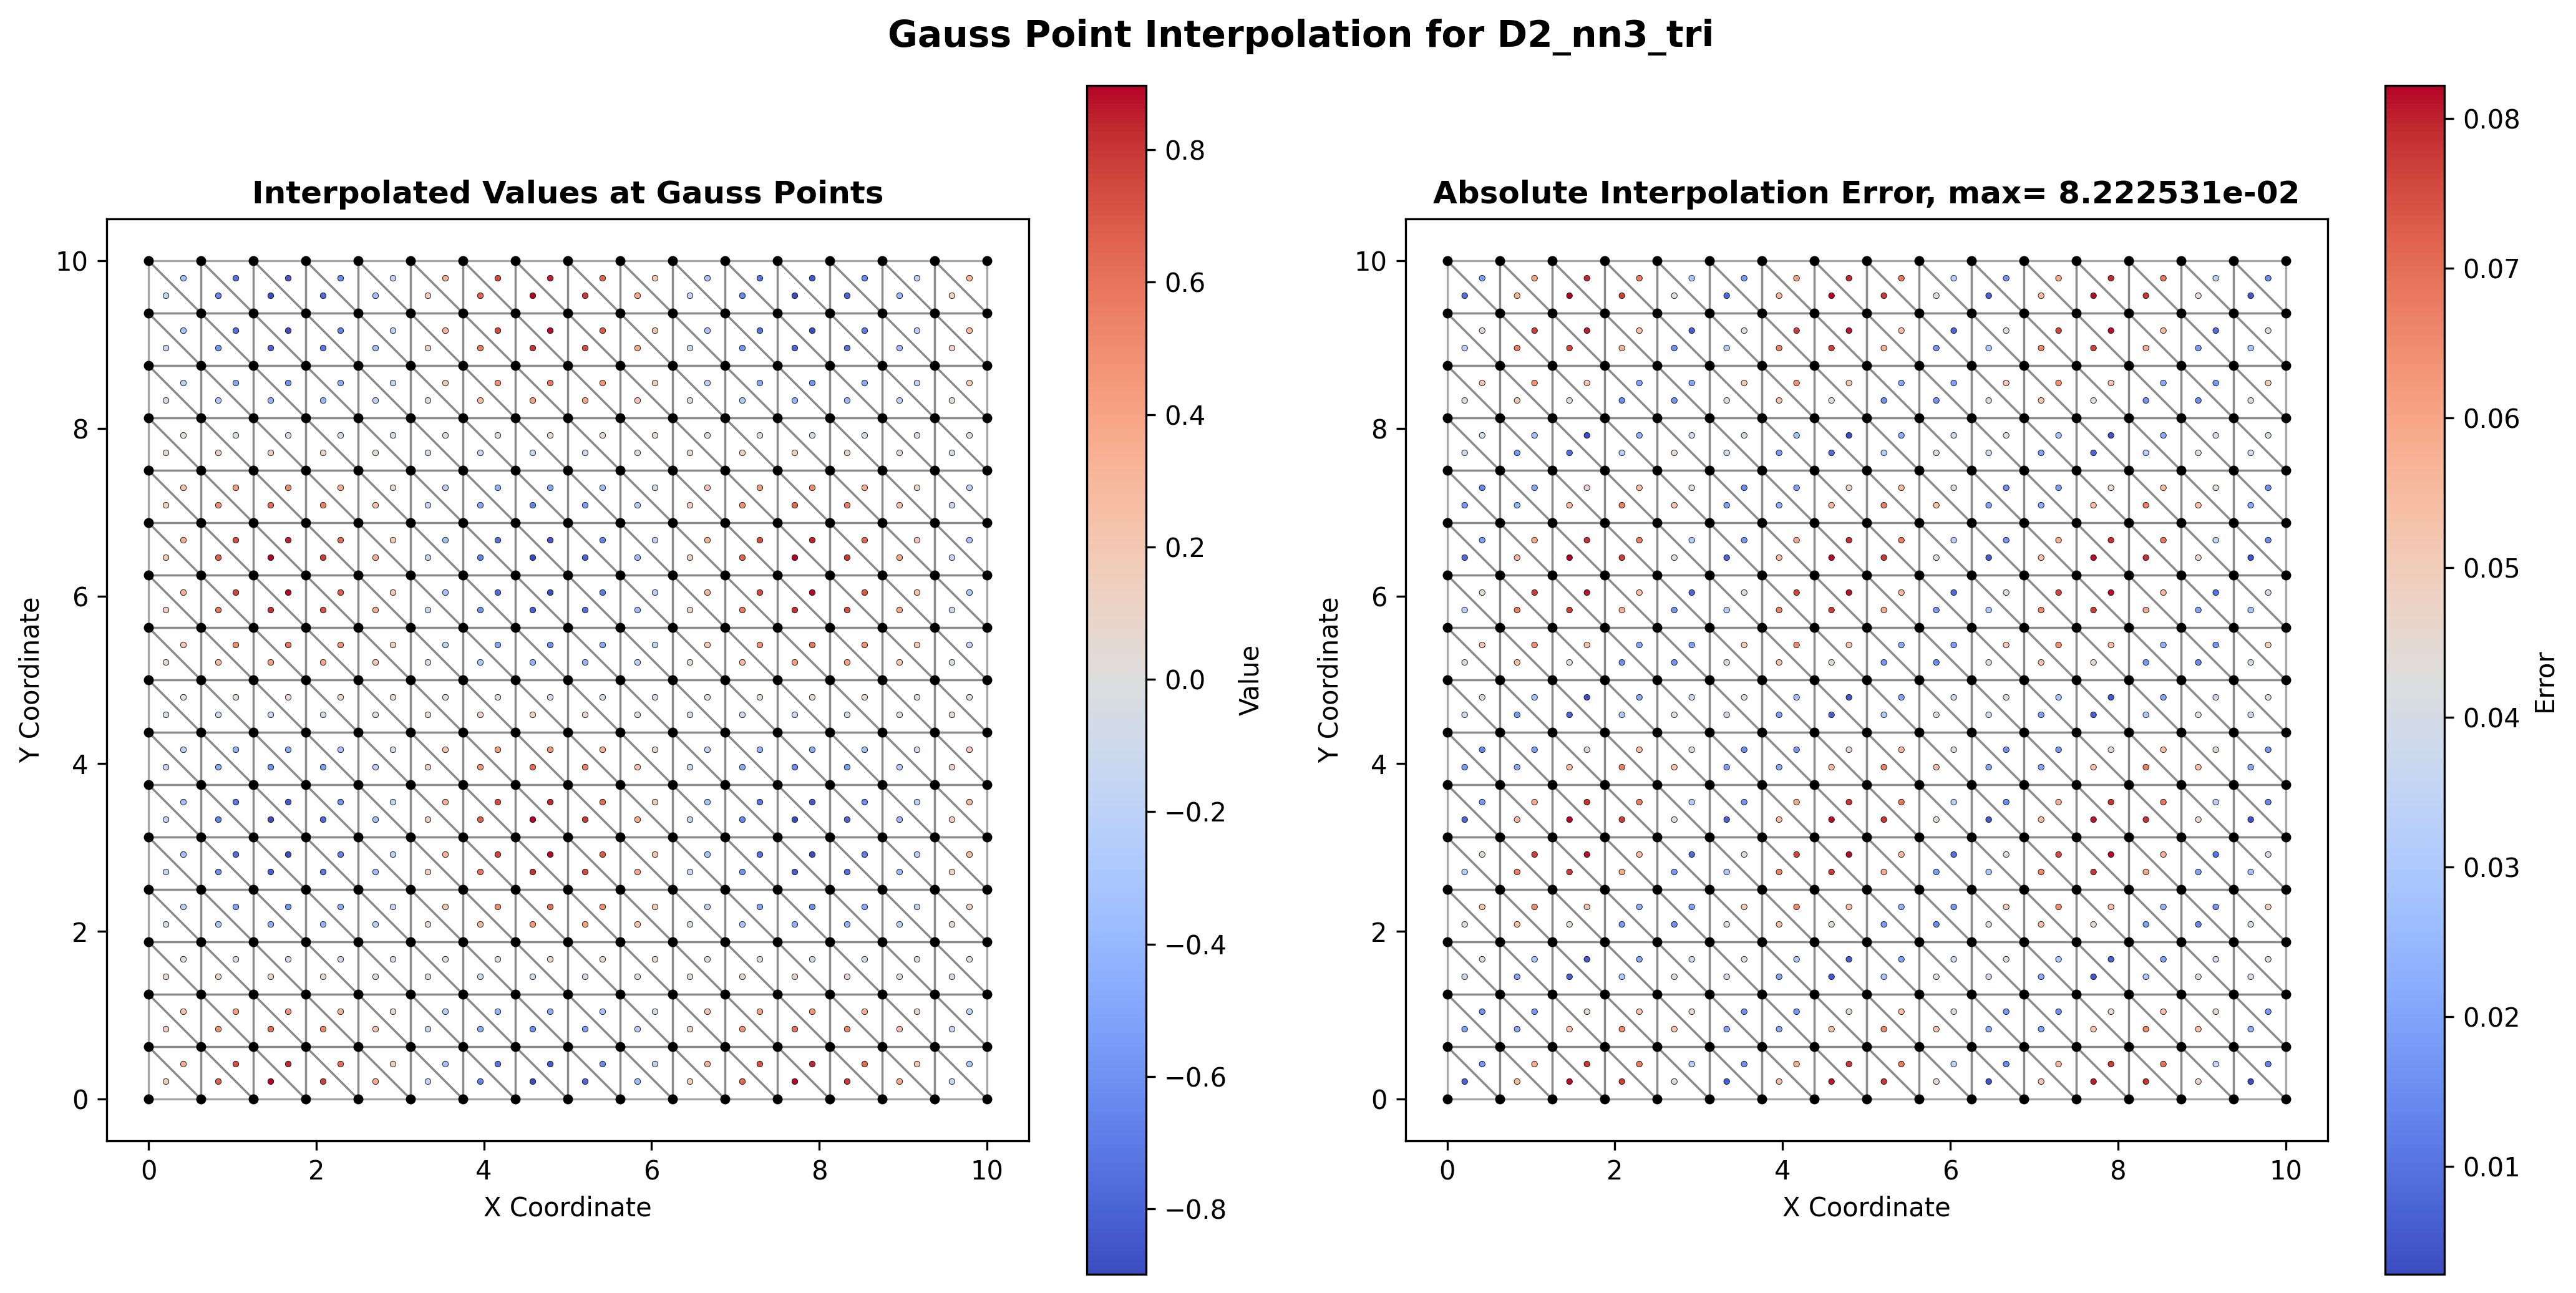

In [2]:
# Demonstrate h-refinement
fcn_interp = fcn_interp_1
ele_type = "D2_nn3_tri"
num_gauss_pts = 1

for val in [2, 4, 8, 16]:
    nx = val
    ny = val
    fname = "h_refine_example_" + ele_type + "_nx%i_ny%i" % (nx, ny) + ".png"
    refinement_example(fname, ele_type, num_gauss_pts, nx, ny, fcn_interp)

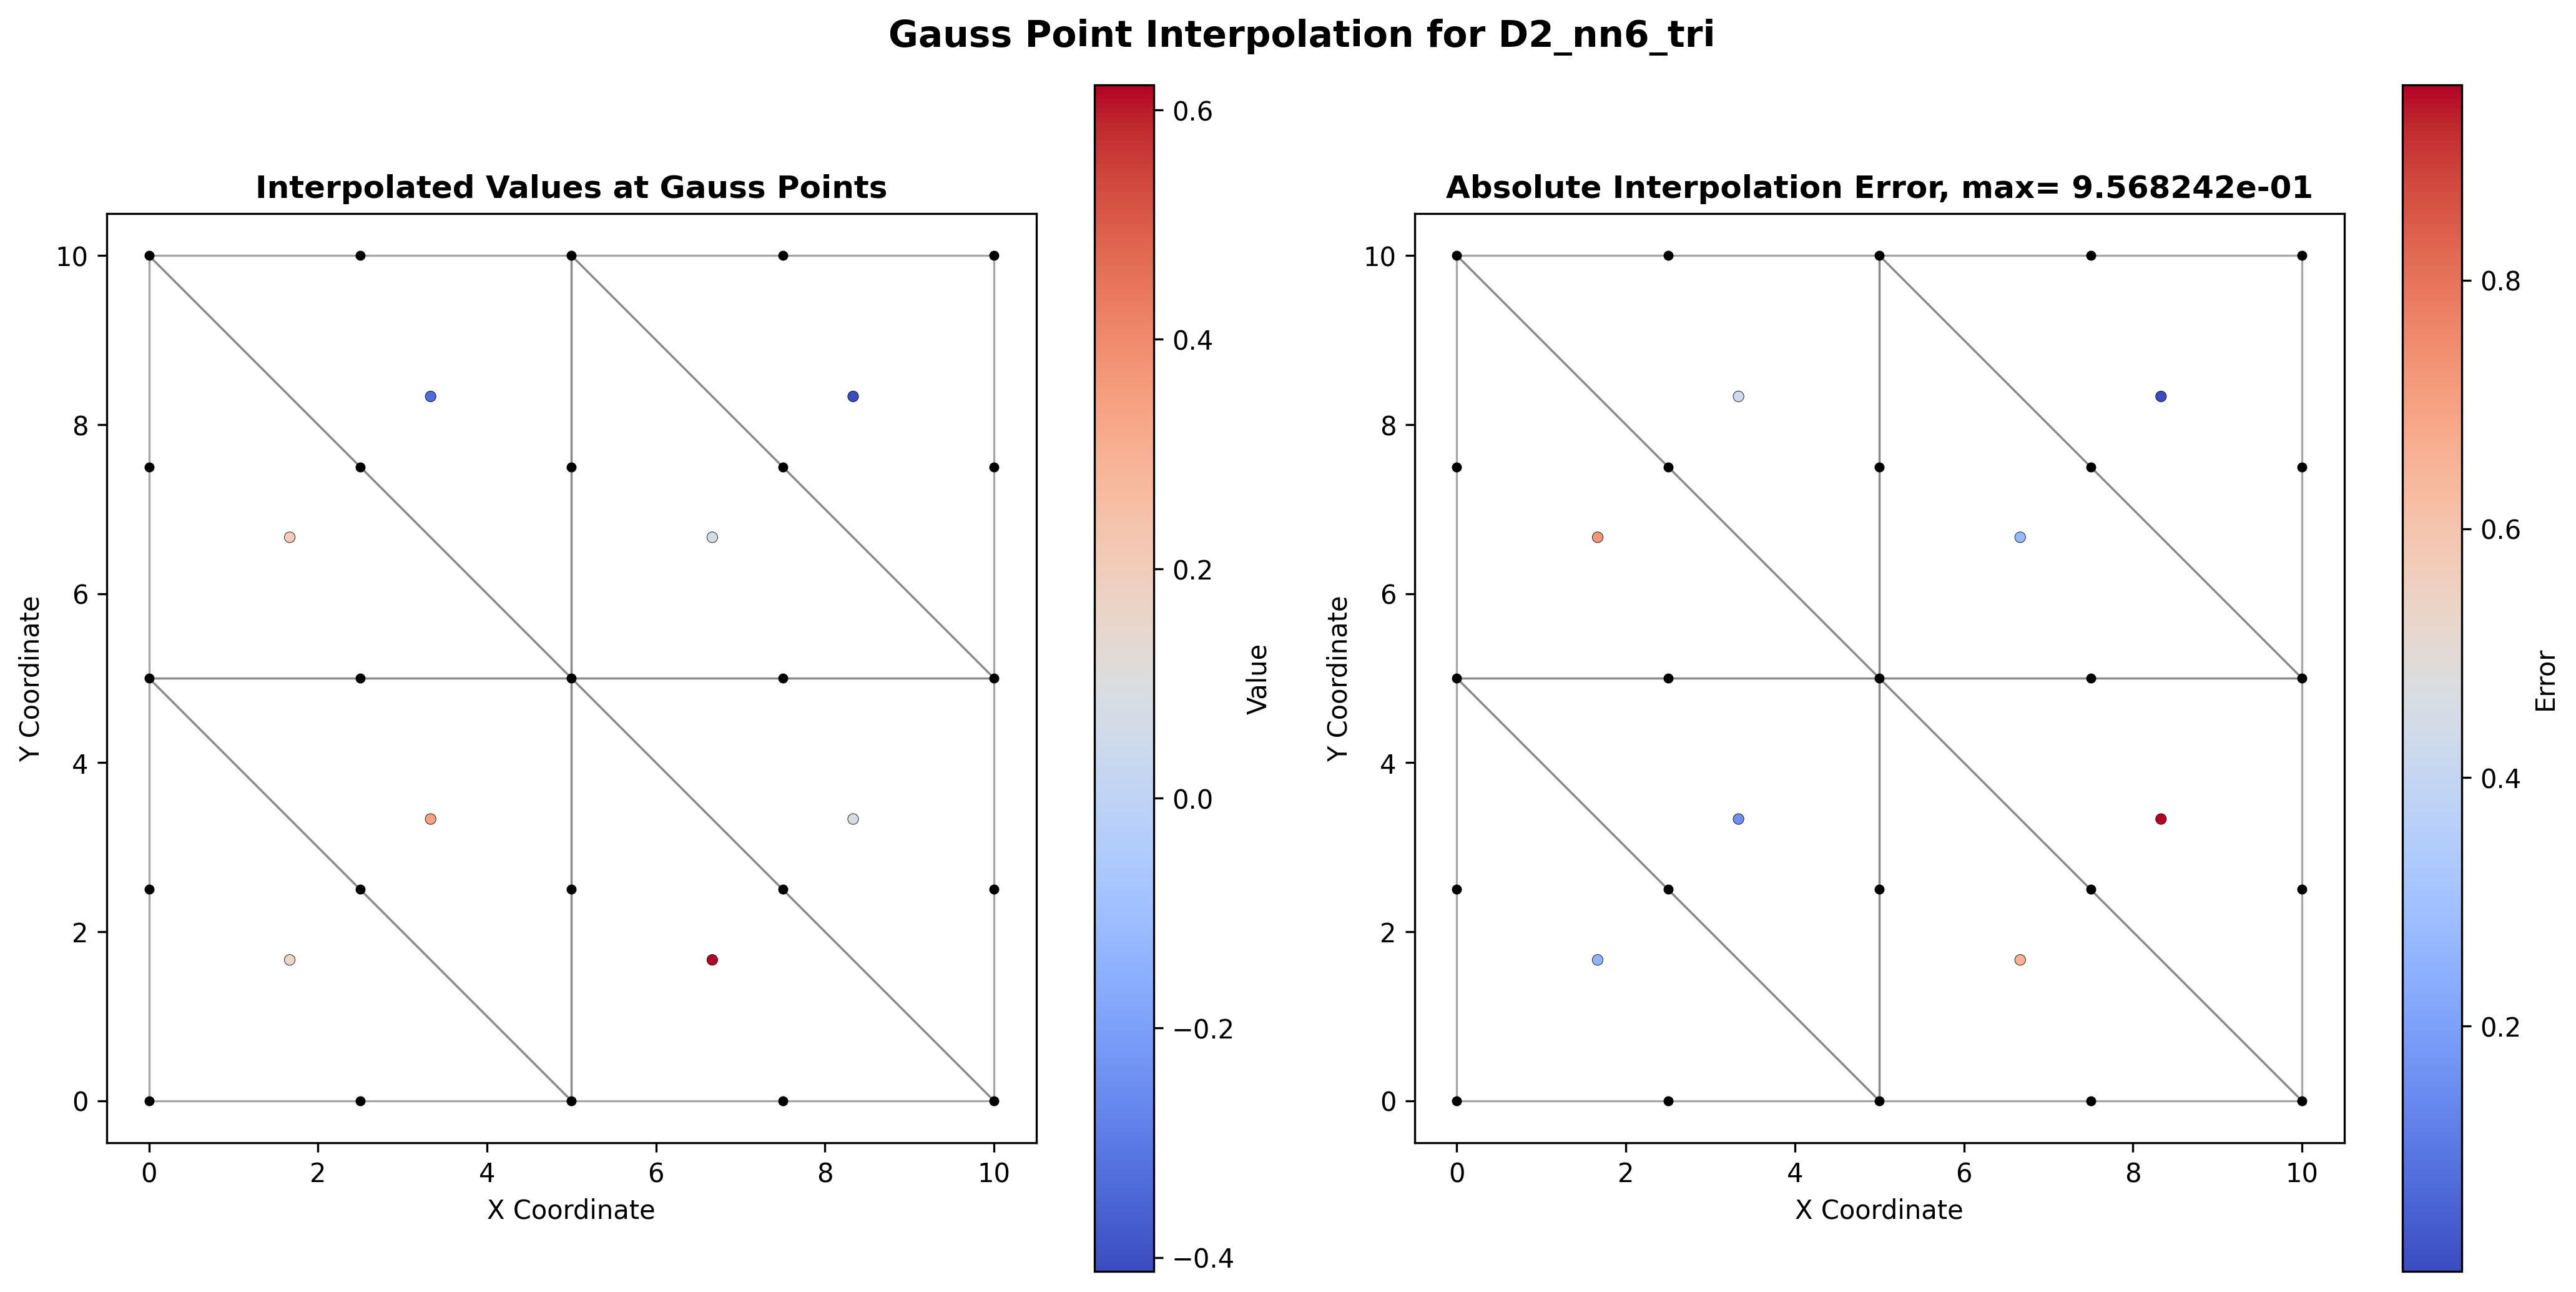

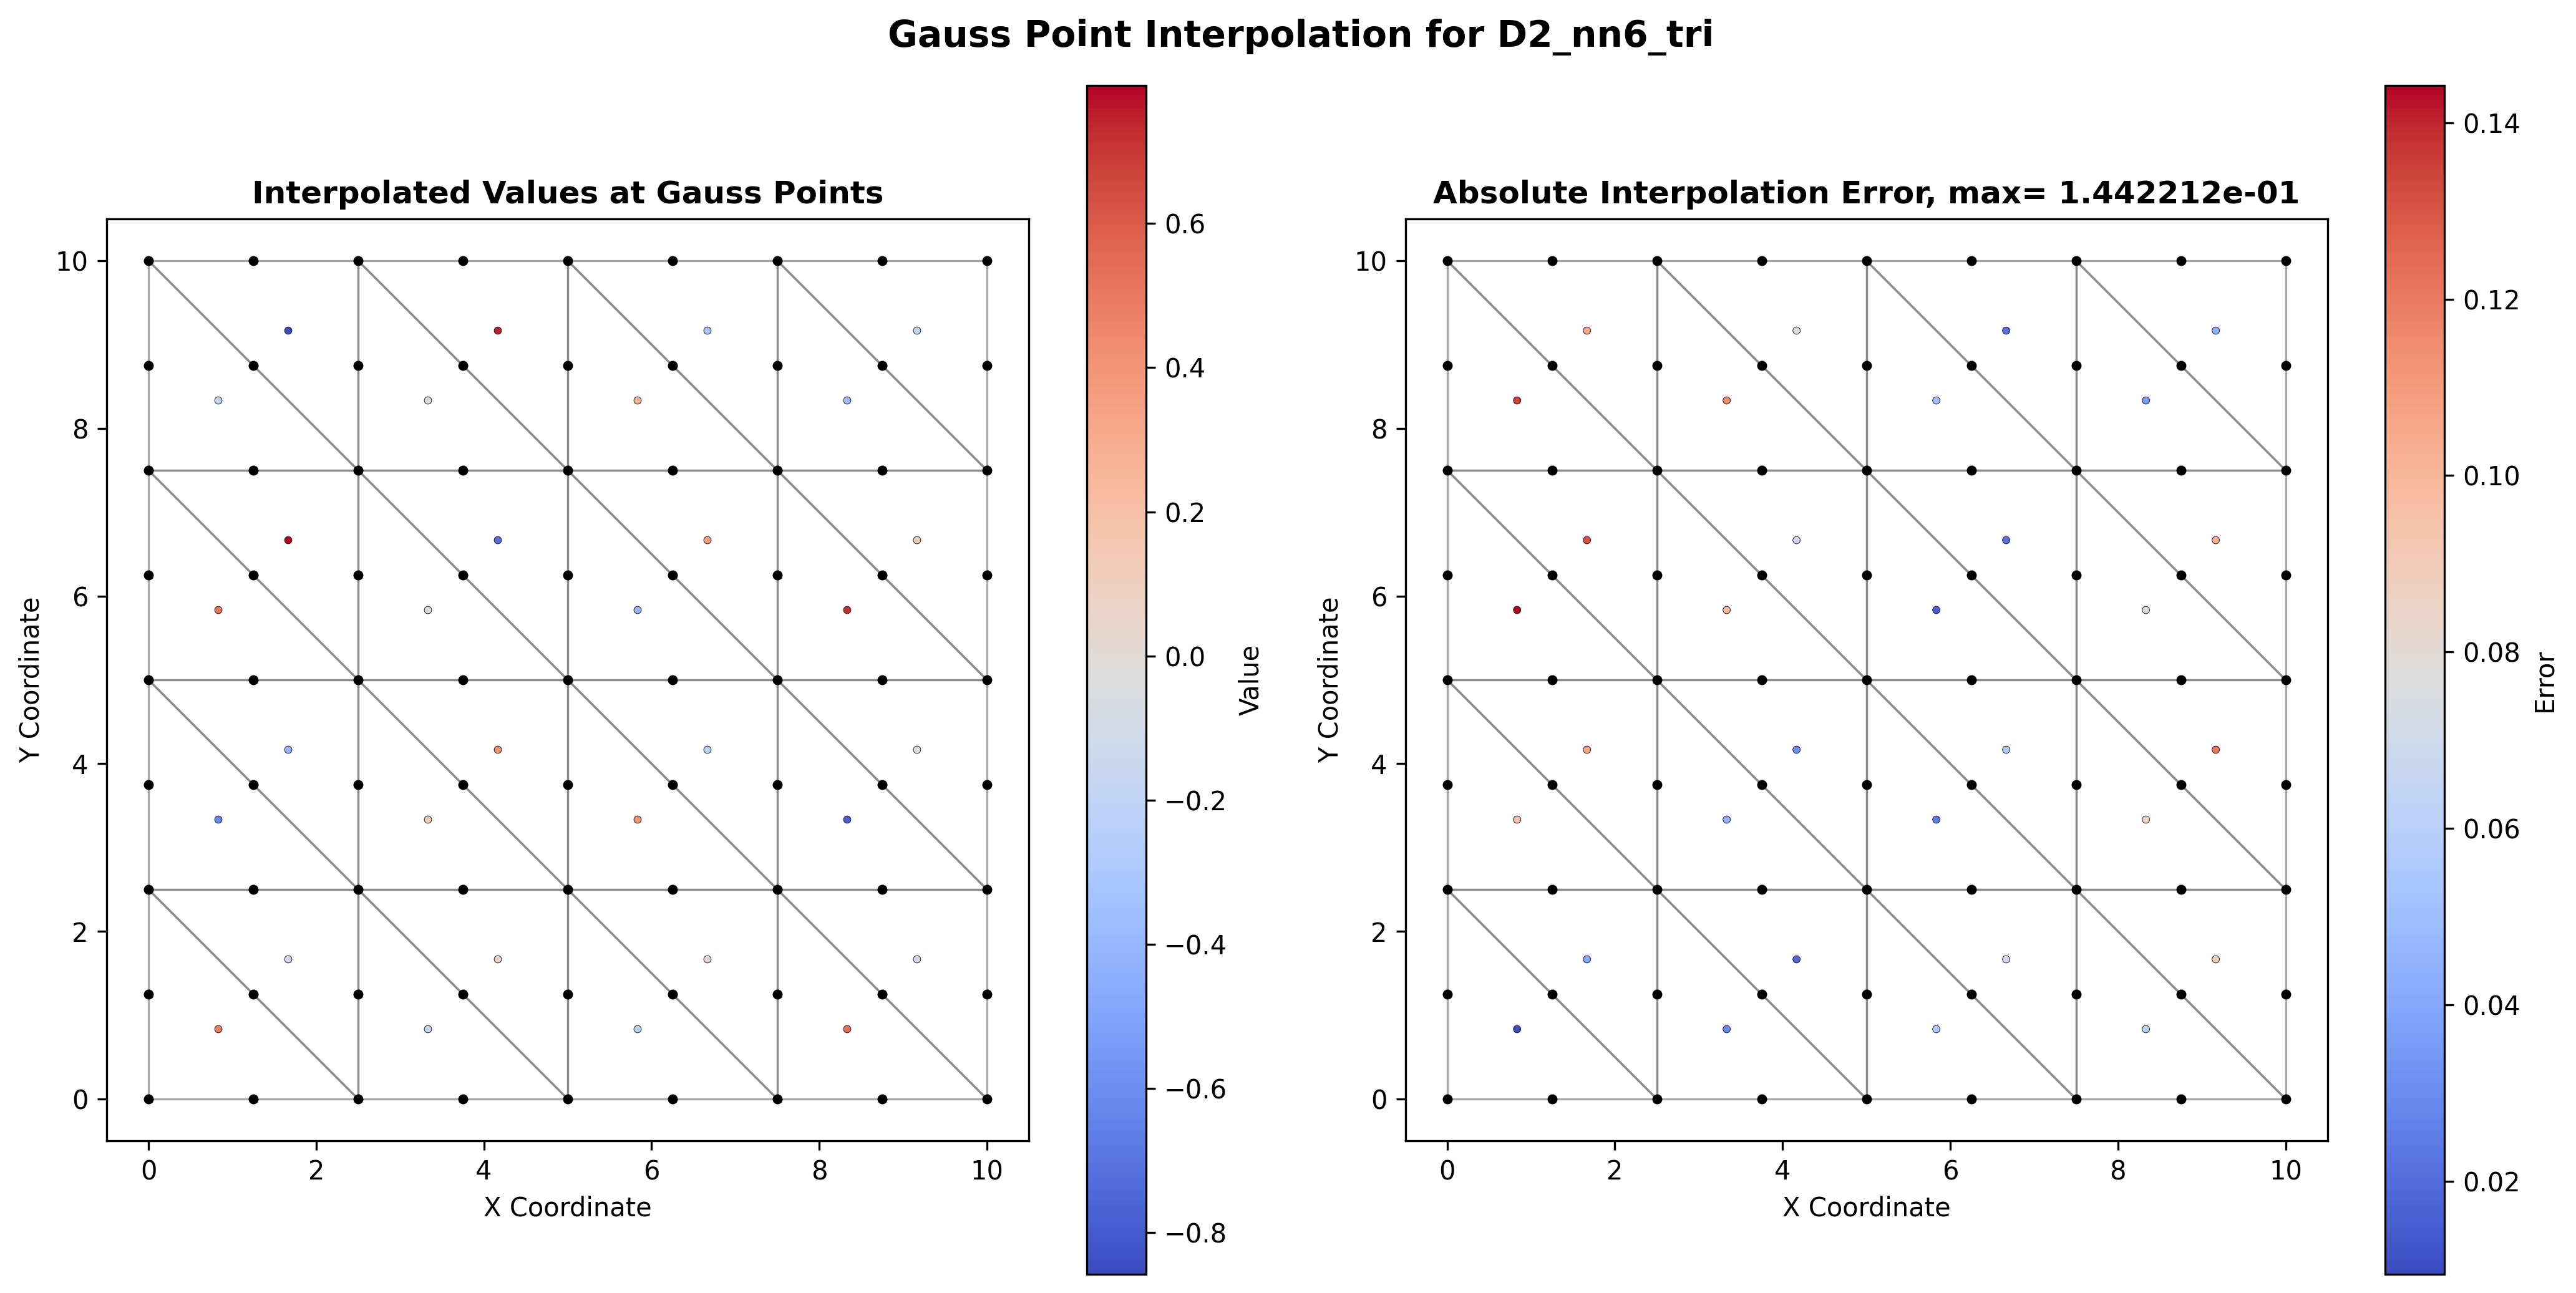

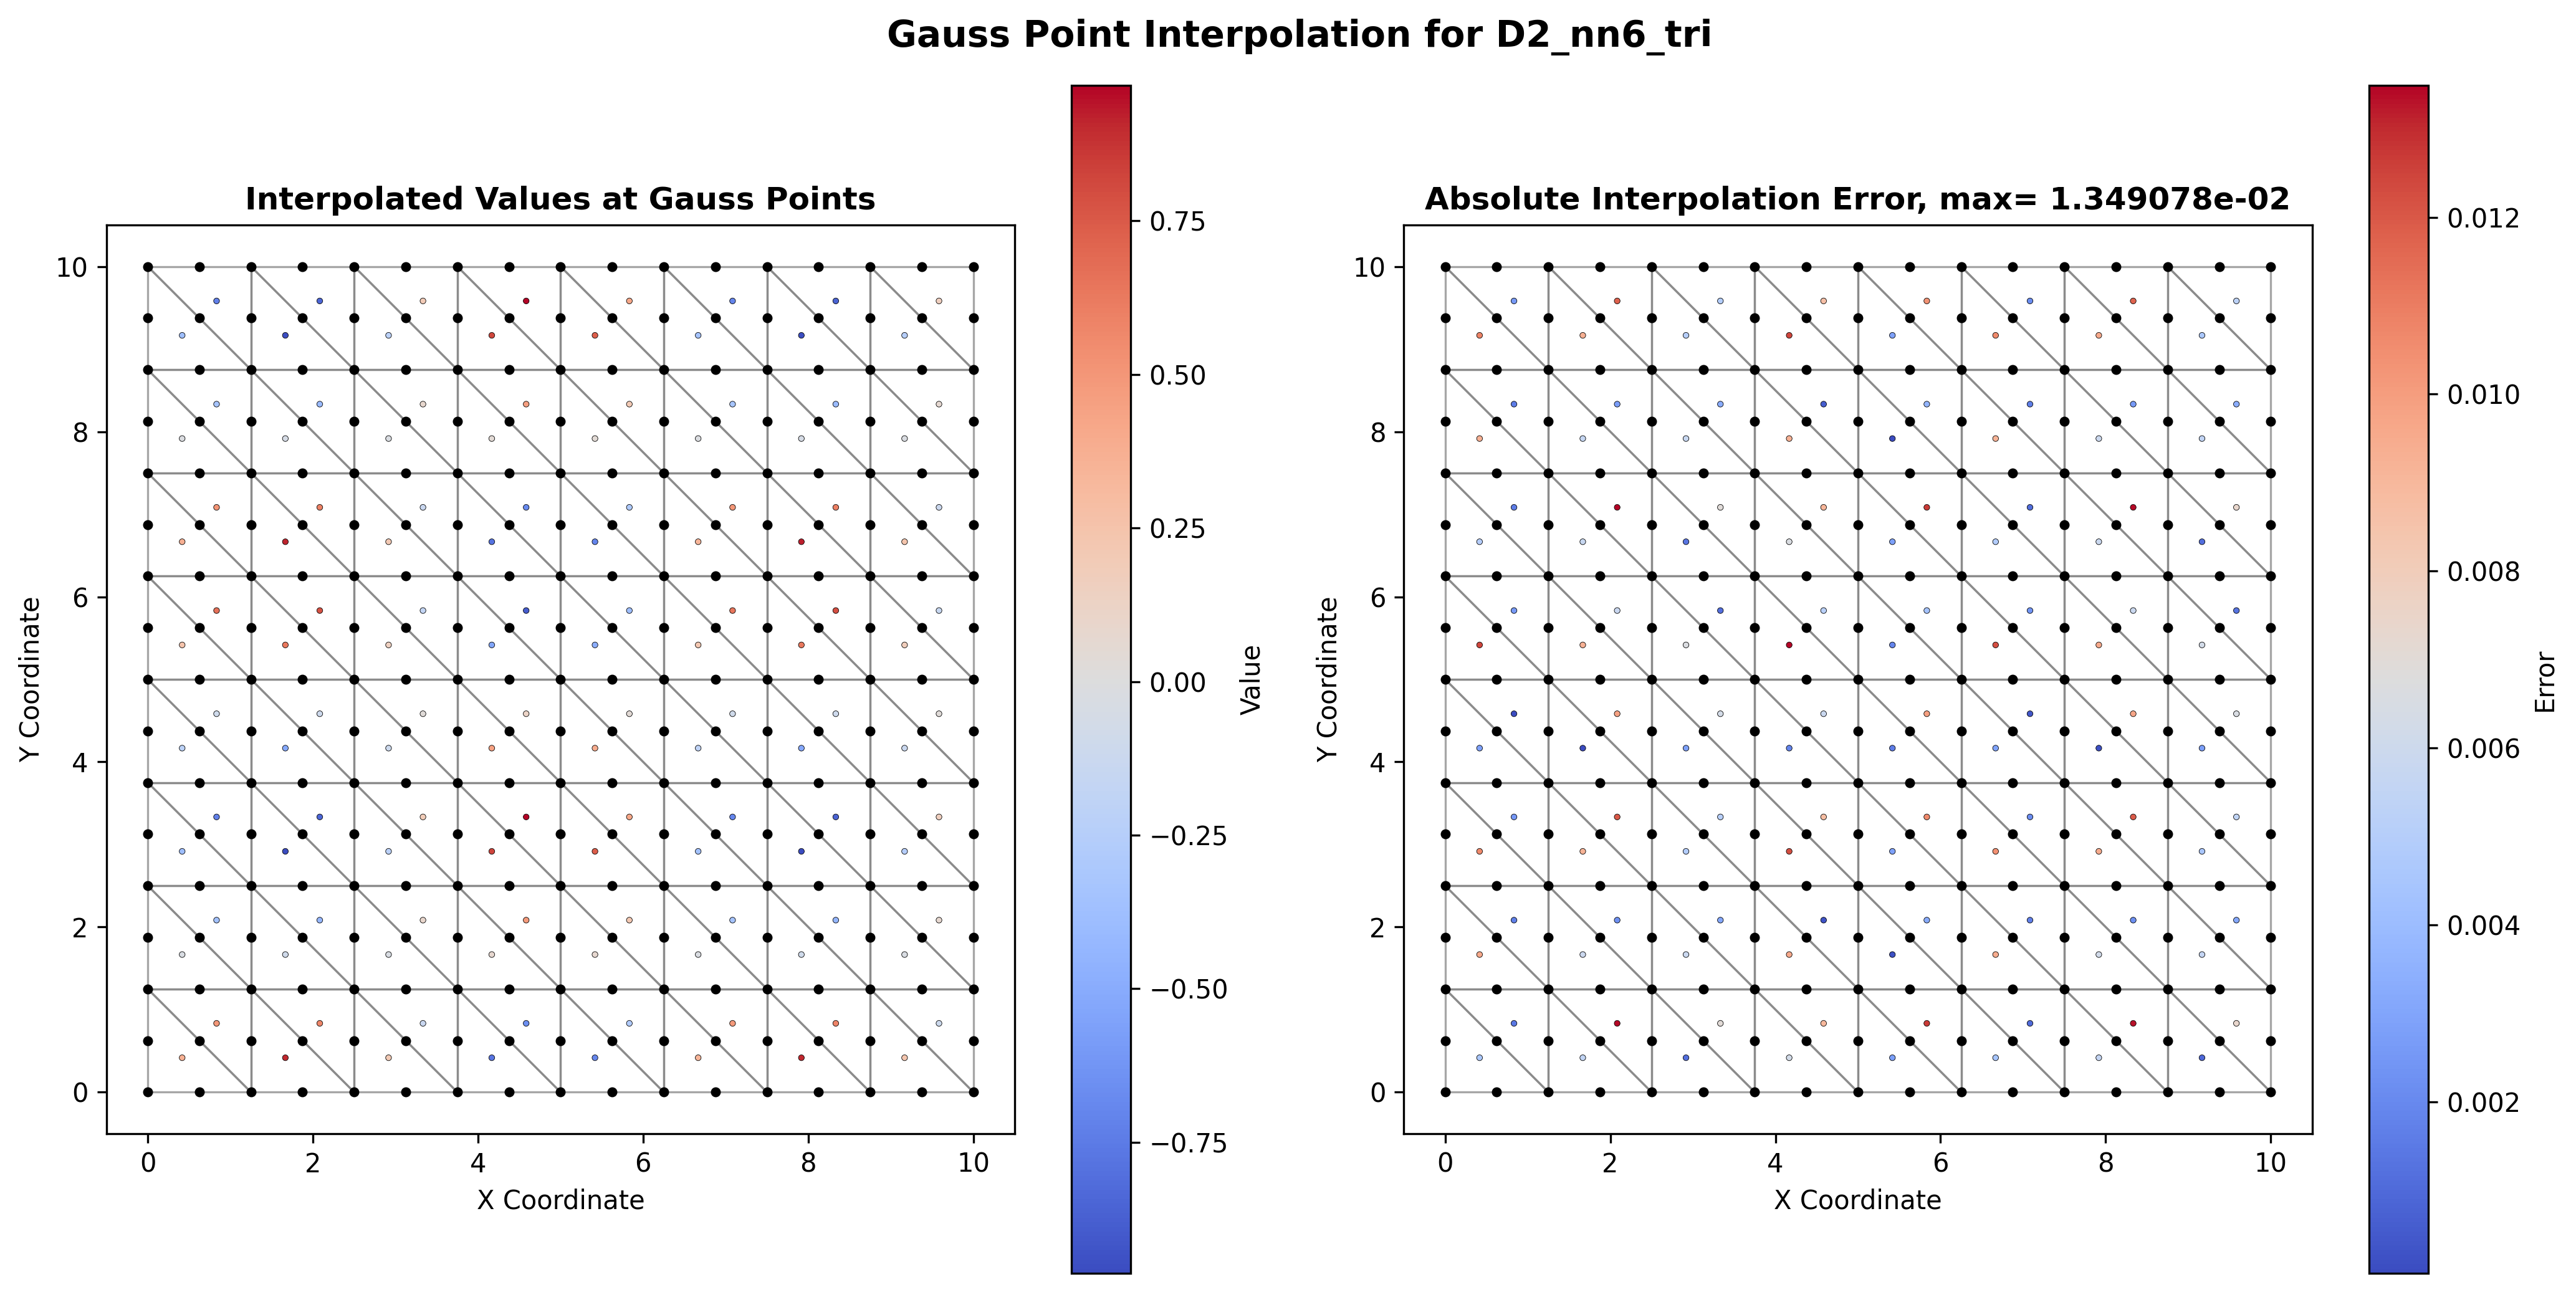

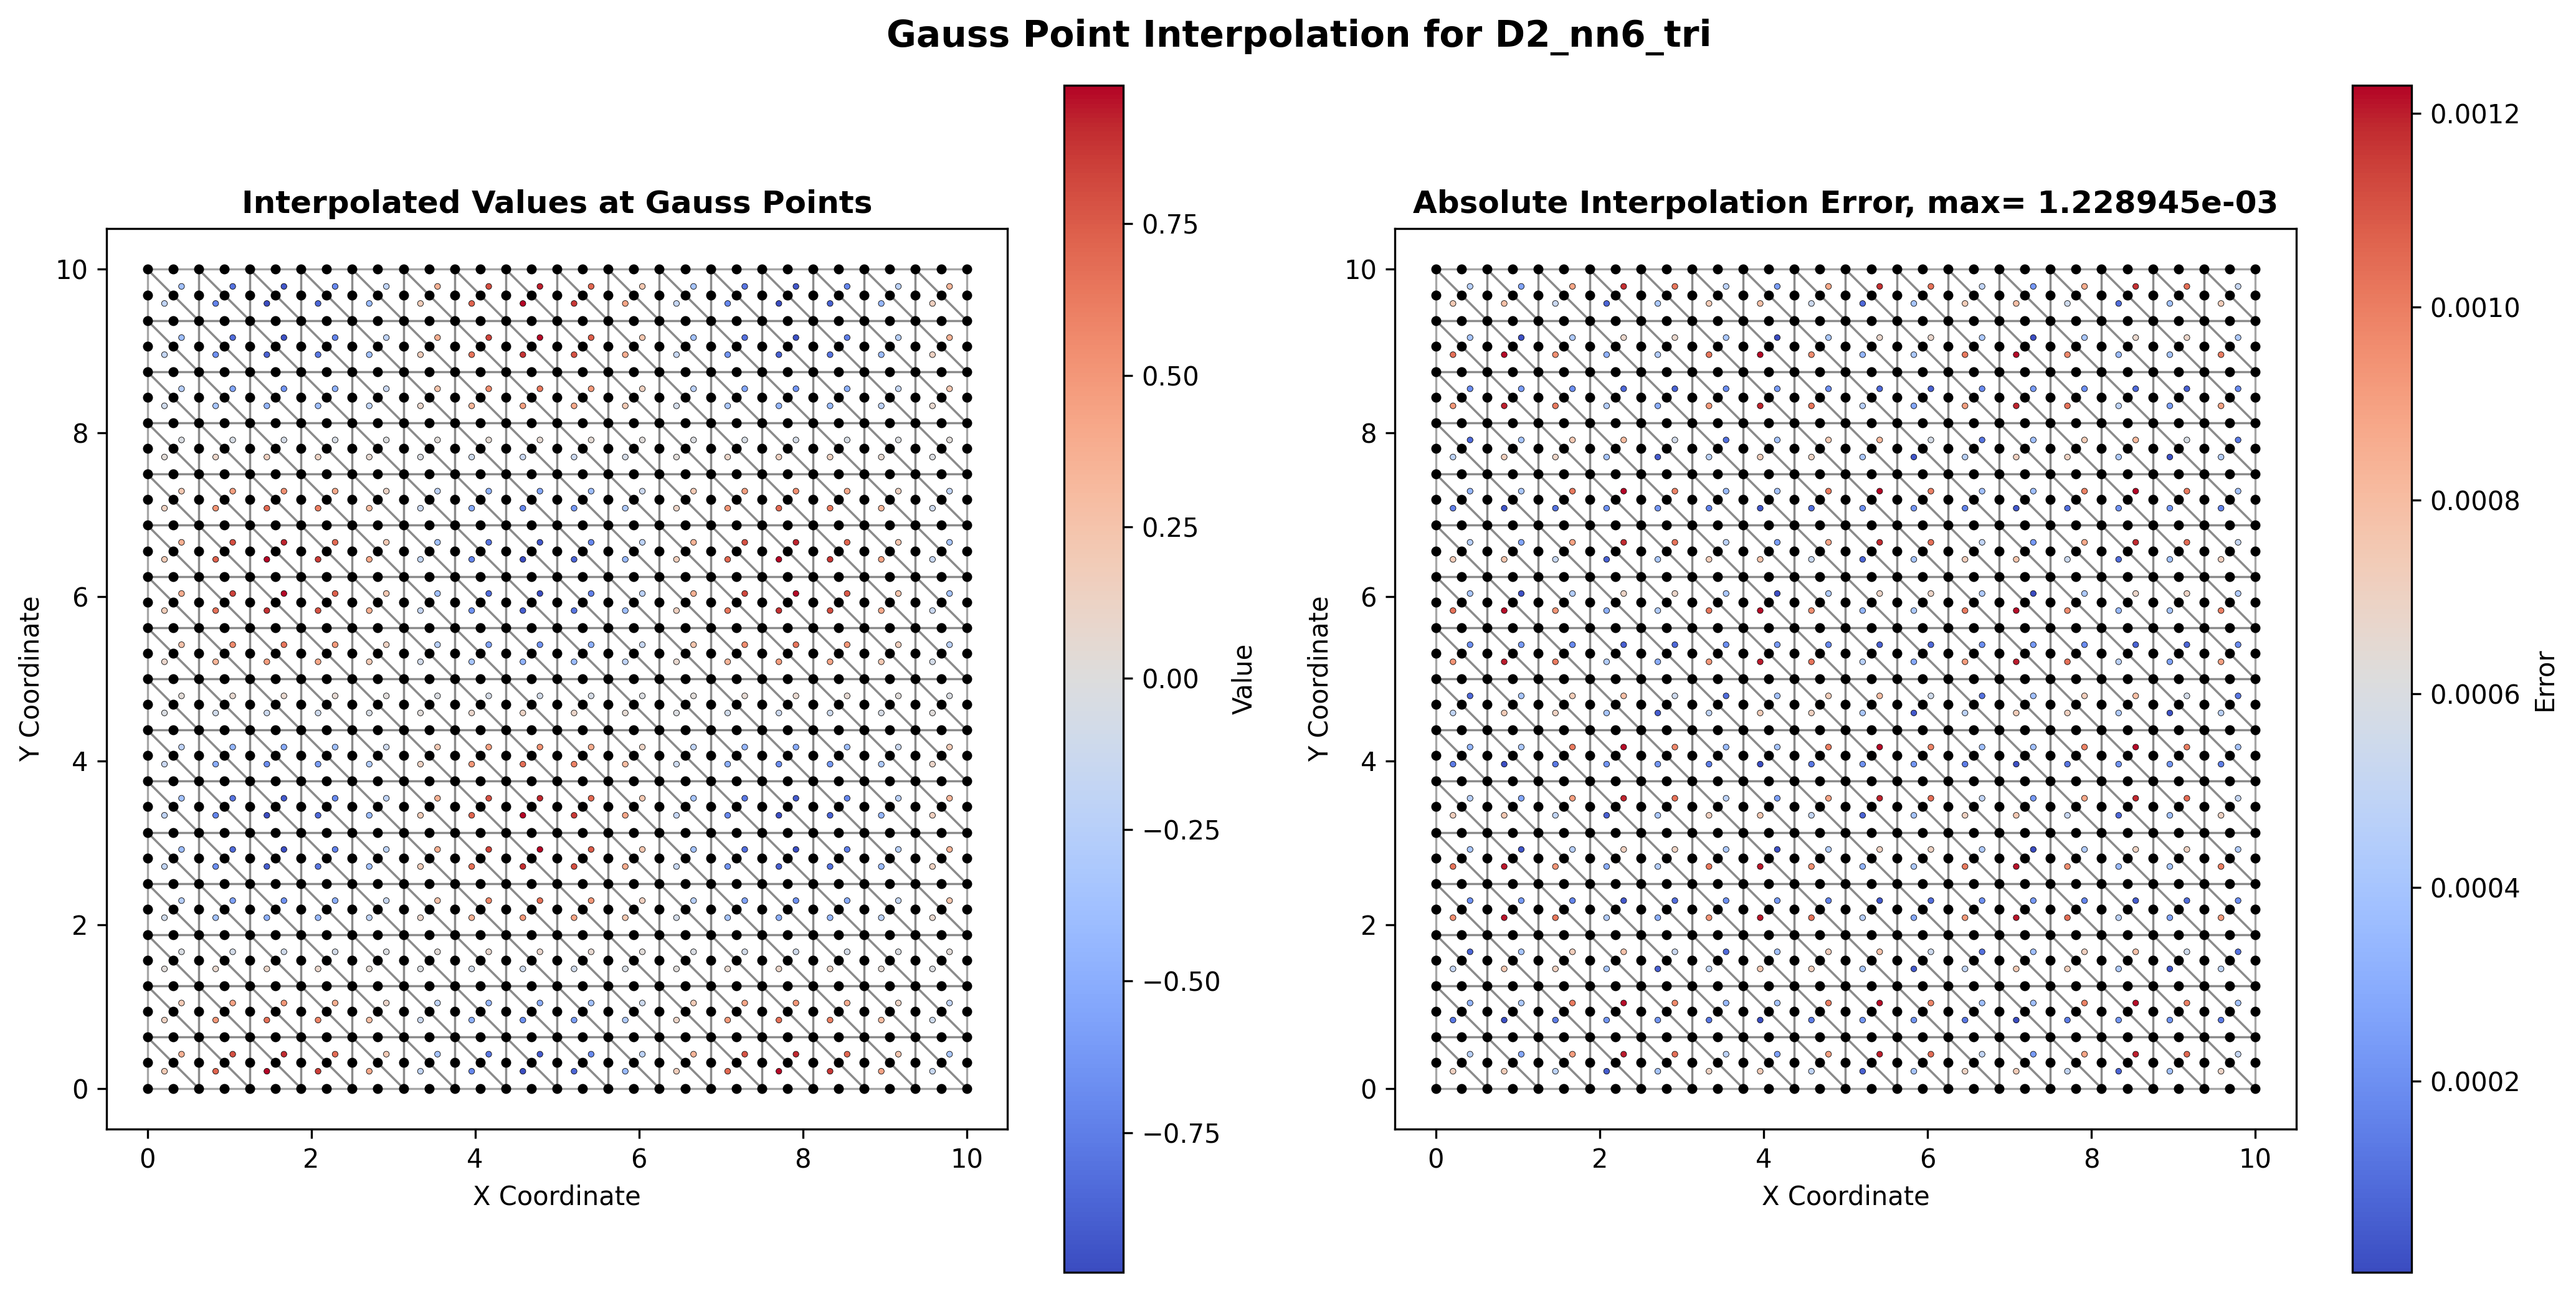

In [3]:
# Demonstrate p-refinement
fcn_interp = fcn_interp_1
ele_type = "D2_nn6_tri"
num_gauss_pts = 1

for val in [2, 4, 8, 16]:
    nx = val
    ny = val
    fname = "p_refine_example_" + ele_type + "_nx%i_ny%i" % (nx, ny) + ".png"
    refinement_example(fname, ele_type, num_gauss_pts, nx, ny, fcn_interp)

In [4]:
import sys
sys.path.append('../src')
import discretization as di
import numpy as np

def condition_number_2x2(matrix: np.ndarray) -> float:
    """
    Computes the 2-norm condition number of a 2x2 matrix.
    
    Parameters
    ----------
    matrix : np.ndarray
        A 2x2 matrix.
    
    Returns
    -------
    float
        The condition number (ratio of largest to smallest singular value).
    """
    if matrix.shape != (2, 2):
        raise ValueError("Input must be a 2x2 matrix.")
    
    sigma = np.linalg.svd(matrix, compute_uv=False)
    return sigma[0] / sigma[1]


def compute_J(coords, shape_fcn_deriv):
    return coords.T @ shape_fcn_deriv

dN_dxi = di.D2_nn3_tri_dxi(np.asarray([0, 0]))
x1, y1 = 0.0, 0.0
x2, y2 = 1.0, 0.0
x3 = 0.5

for y3 in [np.sin(np.pi / 3.0), np.sin(np.pi / 6.0), np.sin(np.pi / 12.0), 0.05, 0.001, 0.0001]:
    coords = np.asarray([[x1, y1], [x2, y2], [x3, y3]])
    J = compute_J(coords, dN_dxi)
    kappa = condition_number_2x2(J)
    print(y3, kappa)

0.8660254037844386 1.732050807568877
0.49999999999999994 1.0
0.25881904510252074 1.9318516525781373
0.05 10.0
0.001 499.9999999999999
0.0001 5000.0


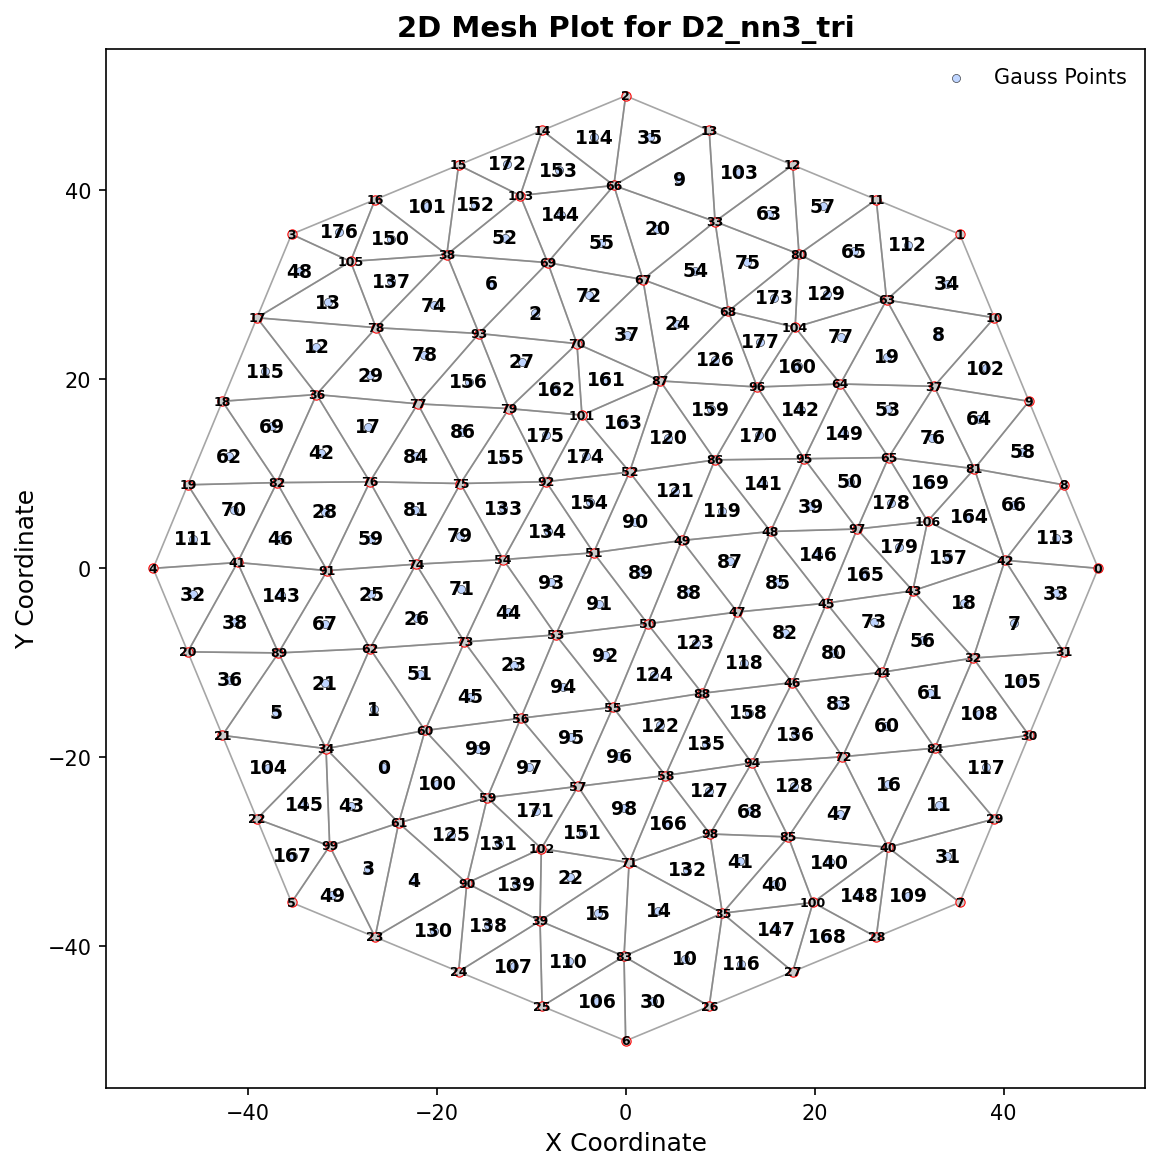

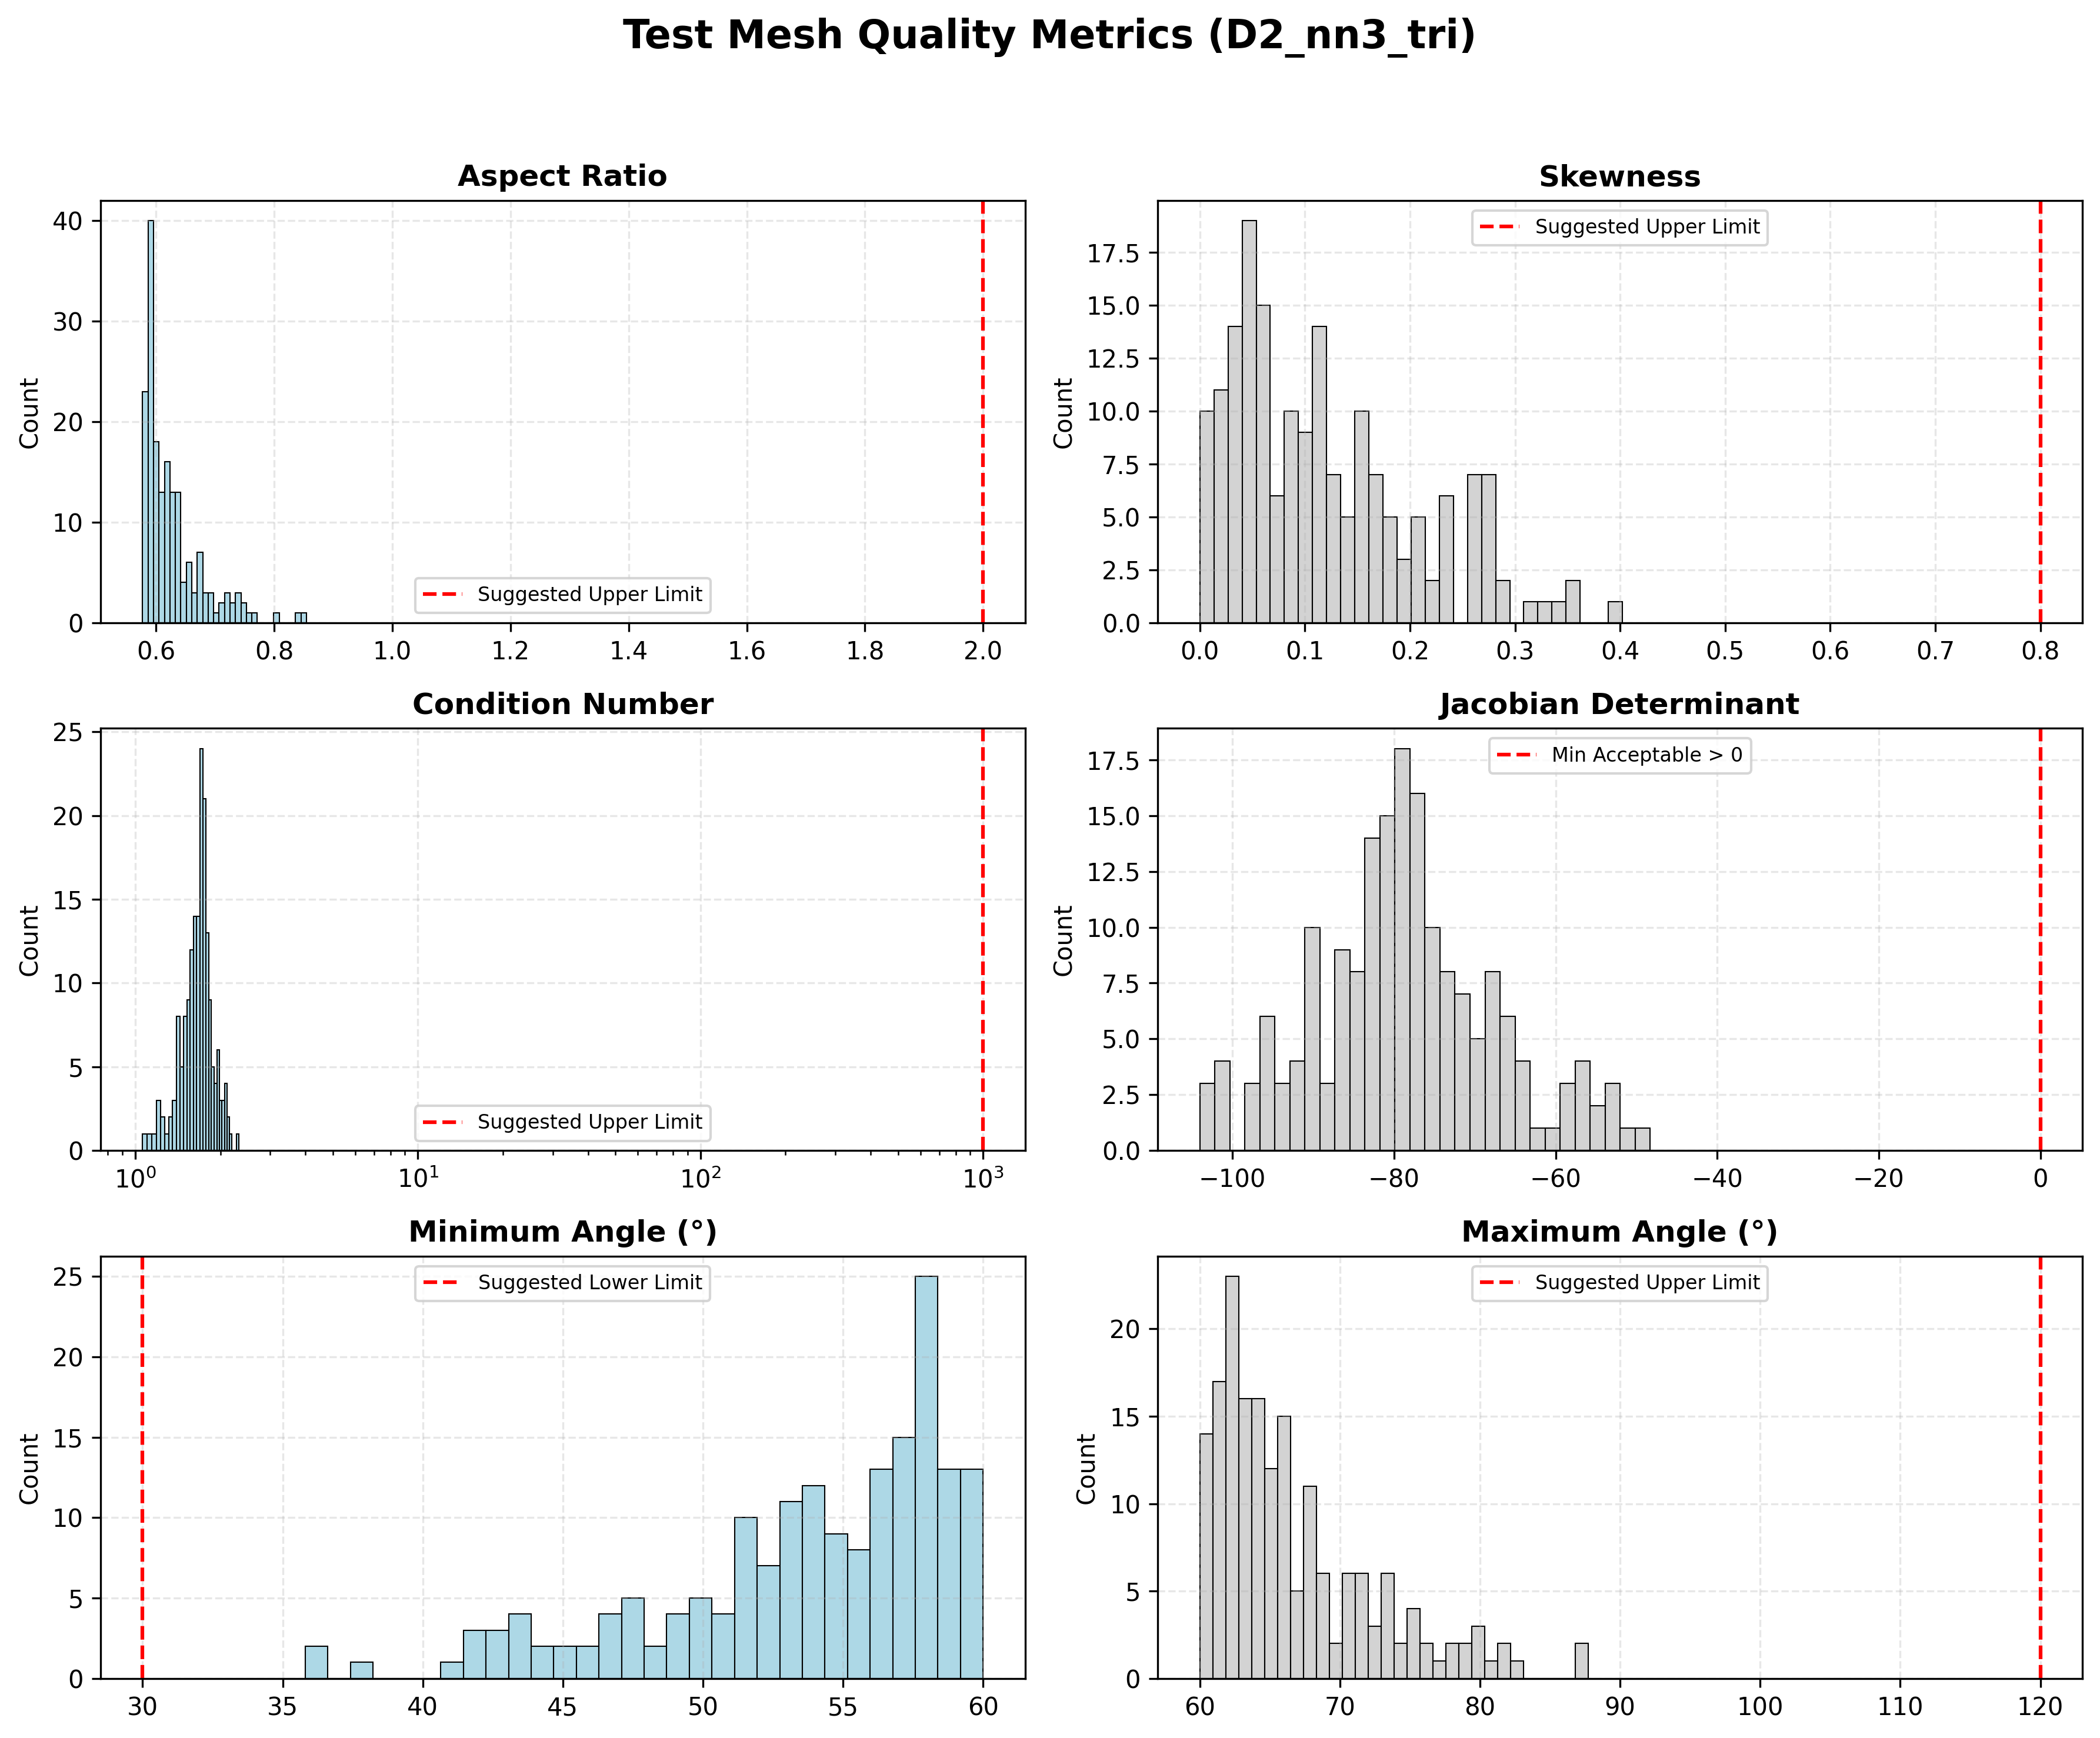

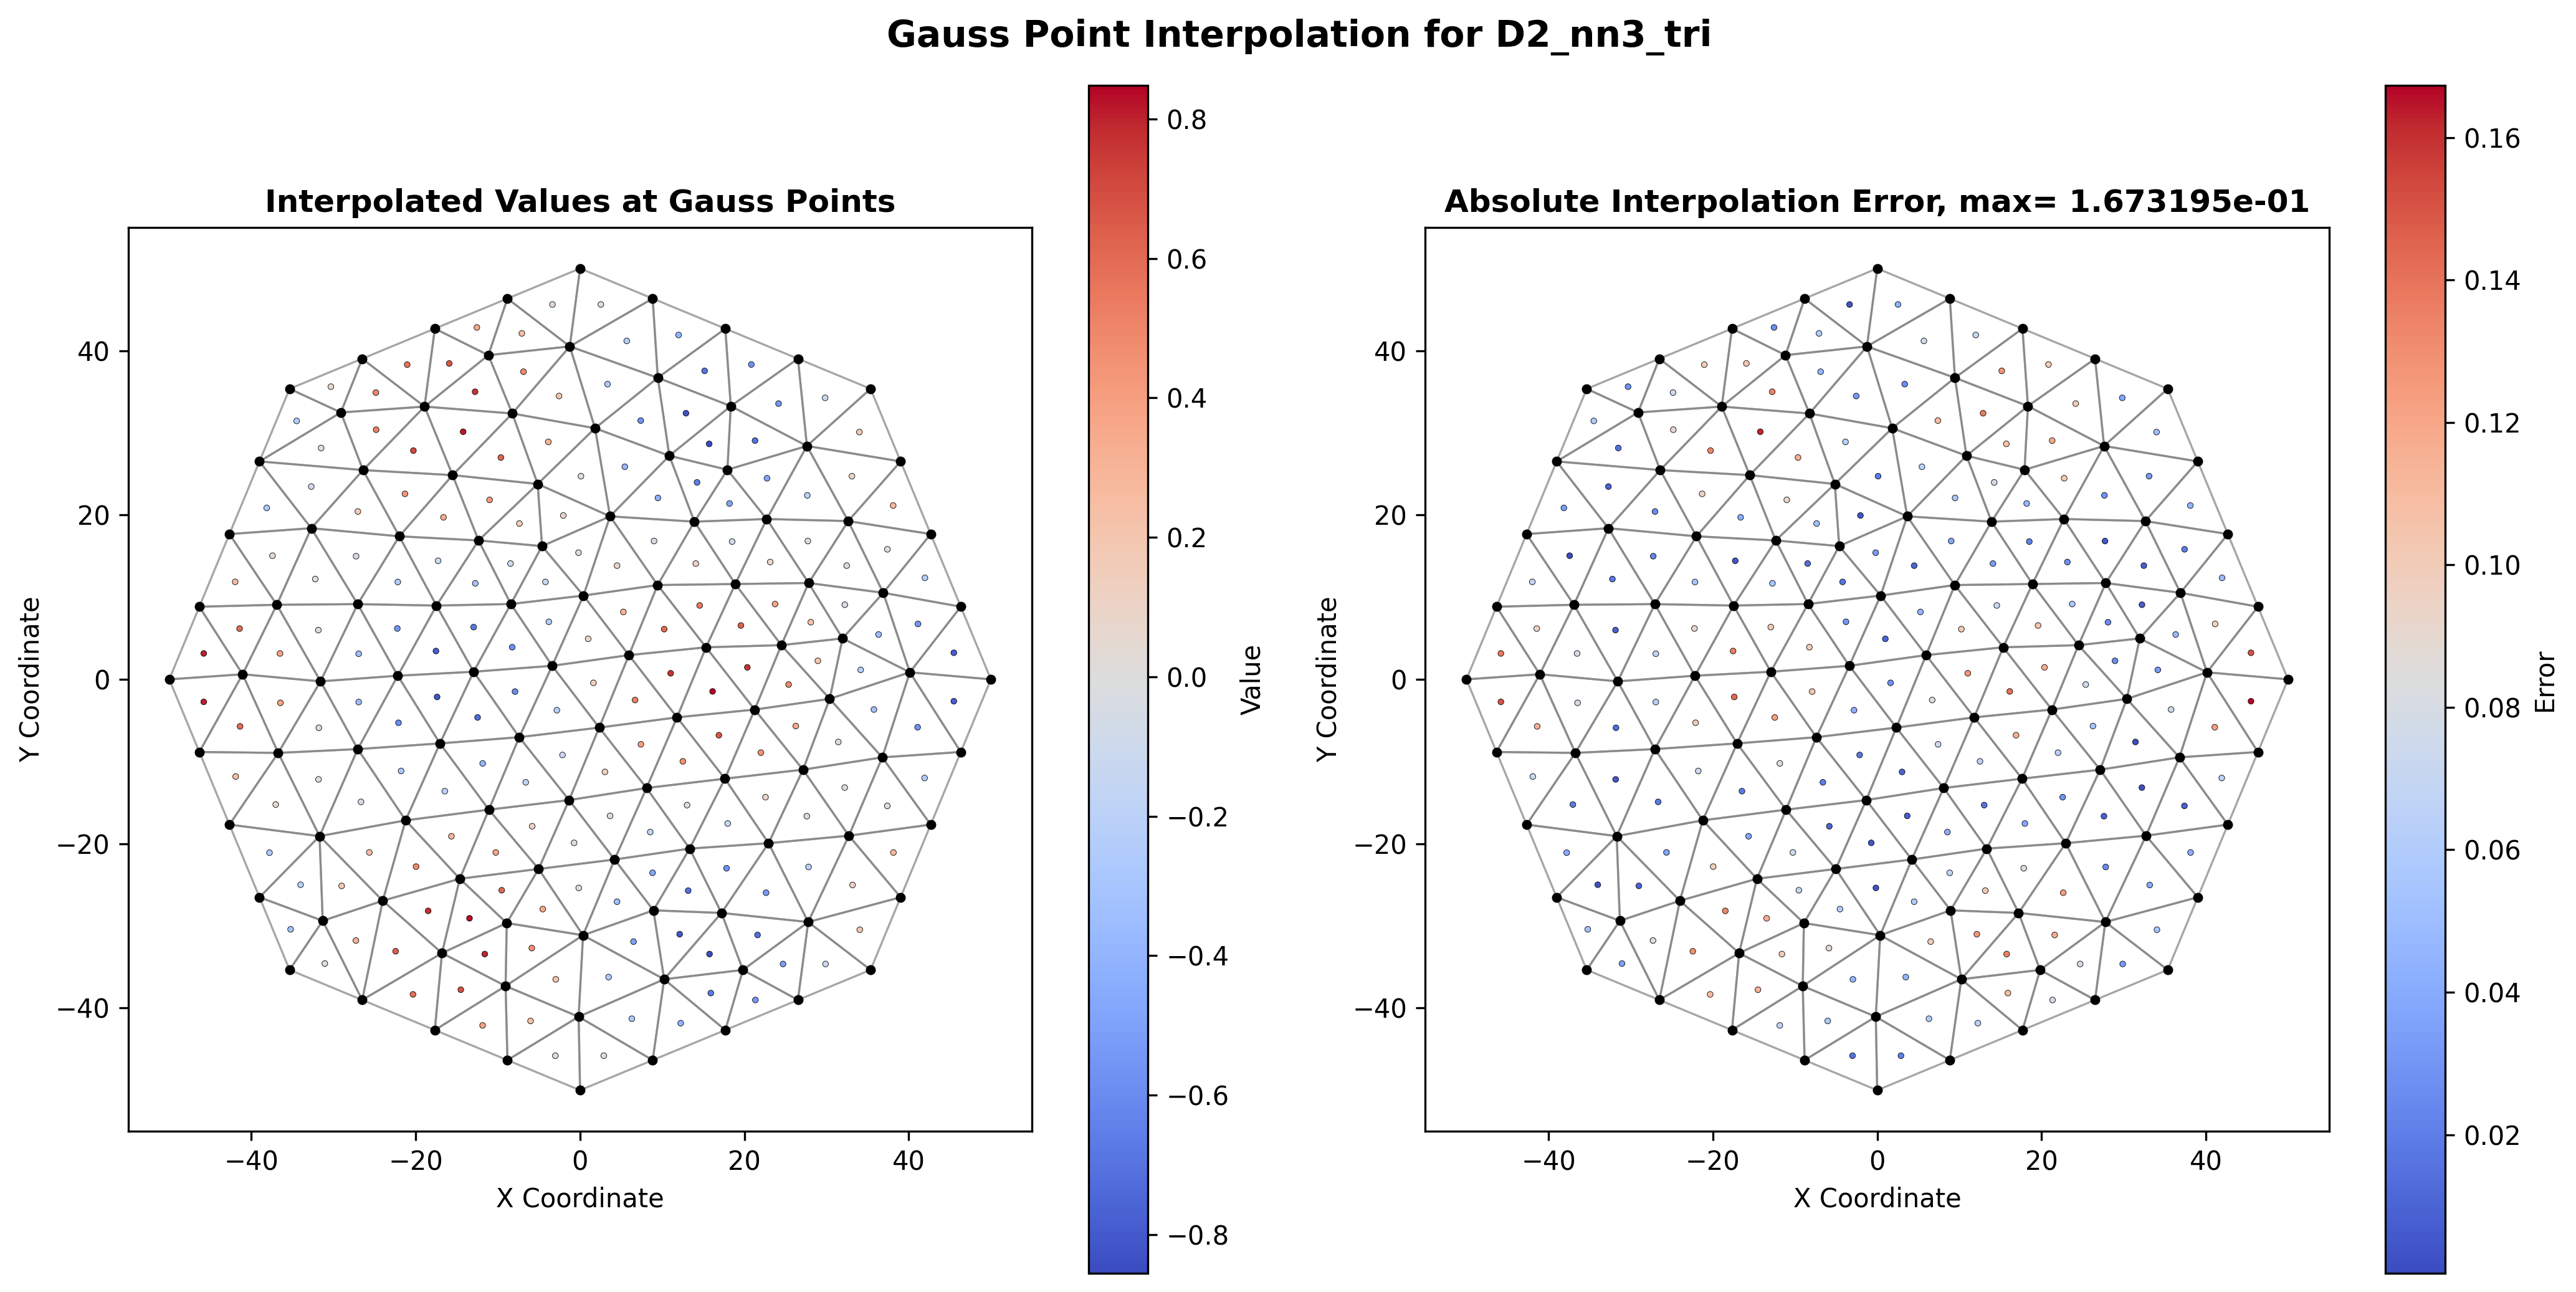

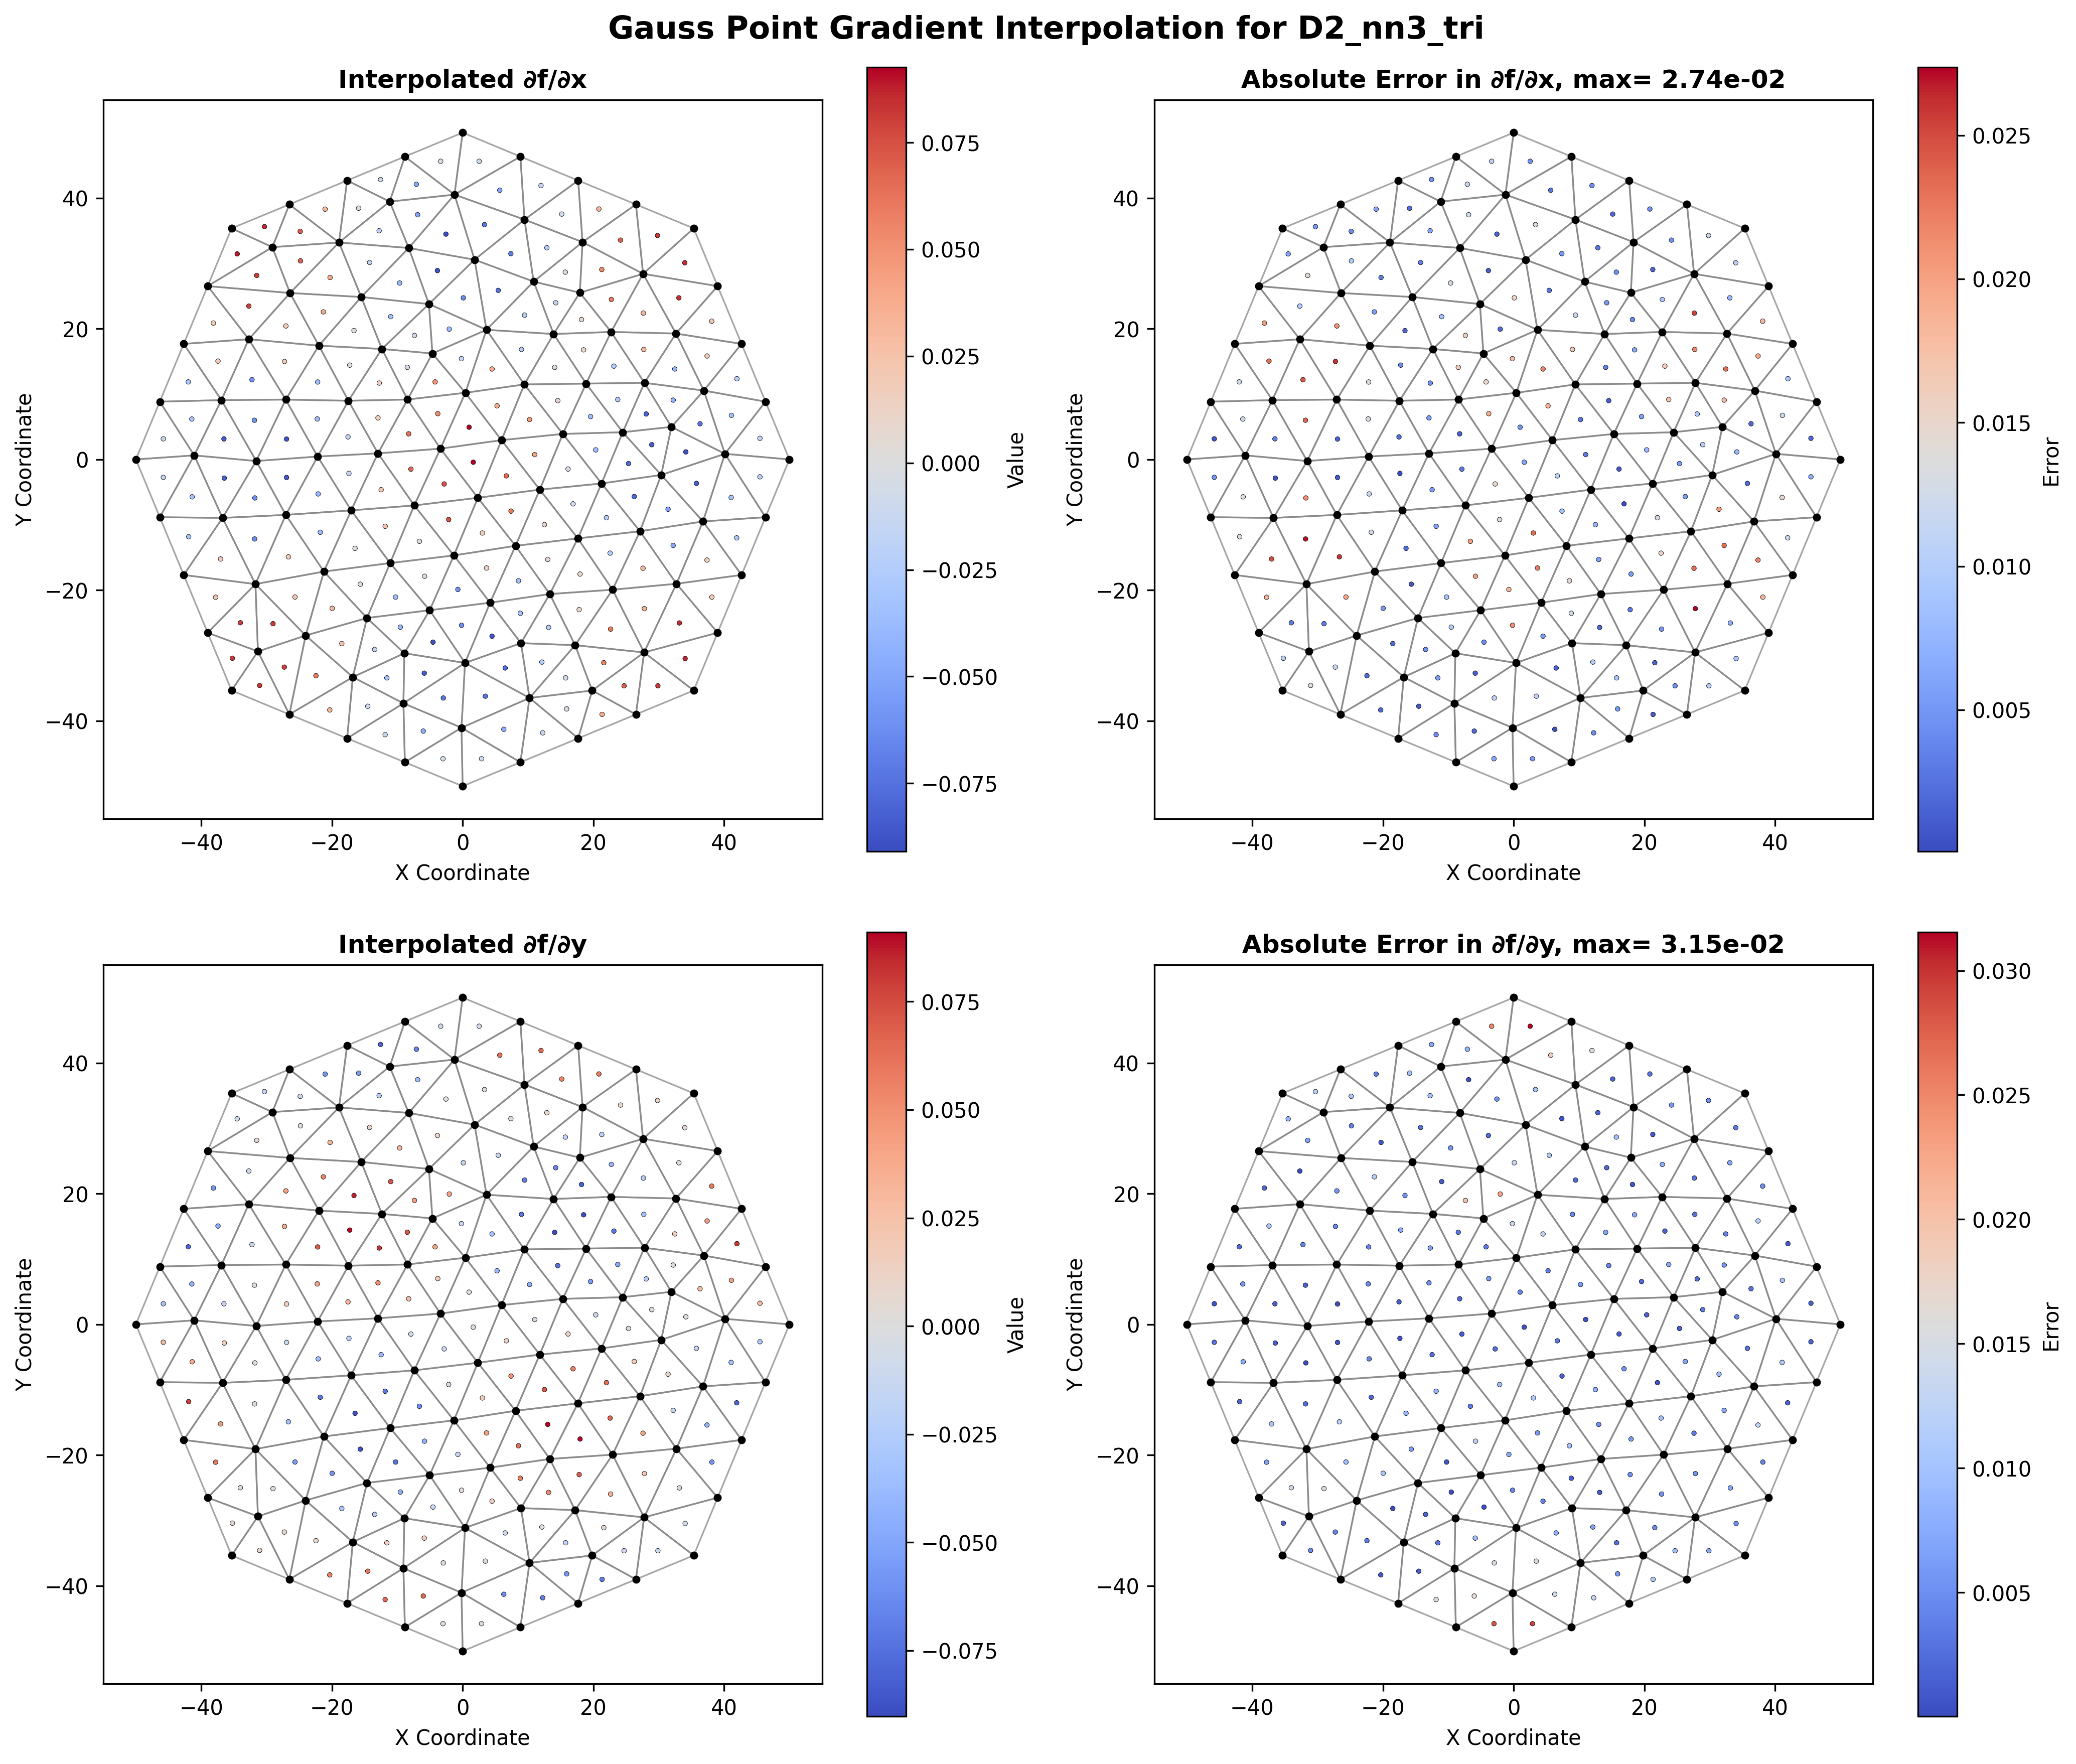

In [1]:
import sys
sys.path.append('../src')
import pre_process as pre
import sys
sys.path.append('../src')
import pre_process_demo_helper_fcns as pre_demo
import numpy as np

def fcn_interp_1(x, y):
    return np.sin(x / 10.0) * np.cos(y / 10.0)

def fcn_interp_deriv_1(x, y):
    df_dx = np.cos(x / 10.0) * np.cos(y / 10.0) * 1.0 / 10.0
    df_dy = -np.sin(x / 10.0) * np.sin(y / 10.0) * 1.0 / 10.0
    return np.array([df_dx, df_dy])

# Create mesh
ele_type = "D2_nn3_tri"
num_gauss_pts = 1
mesh_name = f"octagon_mesh_{ele_type}_gp{num_gauss_pts}"
complex_outline = pre.get_octagon_outline(radius=50.0)
mesh_size = 10.0
coords, connect = pre.mesh_outline(complex_outline, ele_type, mesh_name, mesh_size)
mesh_gauss_pts = pre_demo.get_all_mesh_gauss_pts(ele_type, num_gauss_pts, coords, connect)

# Plot mesh
pre_demo.plot_mesh_2D(mesh_name, ele_type, coords, connect, mesh_gauss_pts)

# Create element quality historams
aspect_ratios, skewness, min_angles, max_angles = pre_demo.compute_element_quality_metrics(ele_type, coords, connect)
cond_nums, jac_dets = pre_demo.compute_condition_and_jacobian(ele_type, coords, connect)
plot_file = mesh_name + "_histograms"
pre_demo.plot_element_quality_histograms(
        fname=str(plot_file),
        super_title="Test Mesh Quality Metrics (%s)" % (ele_type),
        ele_type=ele_type,
        cond_nums=cond_nums,
        jac_dets=jac_dets,
        aspect_ratios=aspect_ratios,
        skewness=skewness,
        min_angles=min_angles,
        max_angles=max_angles
    )

# Example interpolation w/ error plots
ground_truth_fcn = fcn_interp_1(mesh_gauss_pts[..., 0], mesh_gauss_pts[..., 1])  # Vectorized evaluation
interpolated = pre_demo.interpolate_scalar_to_gauss_pts(ele_type, num_gauss_pts, fcn_interp_1, coords, connect)
error_plot = mesh_name + "_fcn_errors"
pre_demo.plot_interpolation_with_error(
        str(error_plot),
        ele_type,
        coords,
        connect,
        mesh_gauss_pts,
        interpolated,
        ground_truth_fcn
    )

# Example interpolation of derivatives w/ error plots
ground_truth_grad = np.zeros_like(mesh_gauss_pts)
for kk in range(mesh_gauss_pts.shape[0]):
    for jj in range(mesh_gauss_pts.shape[1]):
        x = mesh_gauss_pts[kk, jj, 0]
        y = mesh_gauss_pts[kk, jj, 1]
        ground_truth_grad[kk, jj] = fcn_interp_deriv_1(x, y)  # should return [∂f/∂x, ∂f/∂y]

# Compute interpolated gradient from nodal values of fcn_3
interpolated_grad = pre_demo.interpolate_scalar_deriv_to_gauss_pts(
    ele_type,
    num_gauss_pts,
    fcn_interp_1,
    coords,
    connect
)

# Save gradient interpolation error plot
grad_error_plot = mesh_name + "_fcn_grad_errors"
pre_demo.plot_interpolation_gradient_with_error(
    str(grad_error_plot),
    ele_type,
    coords,
    connect,
    mesh_gauss_pts,
    interpolated_grad,
    ground_truth_grad
)

